National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Modern Decision Making: Applied Machine Learning

Final Project: Level of income prediction (binary classification)

Student: Andrei Batyrov (Fall2022)

Date: 30-Nov-2023

##### Table of Contents

[Description](#description)

1. [Data exploration](#data-exploration)

2. [Data preprocessing](#data-preprocessing)

3. [Model training](#model-training)

4. [Summary](#summary)

In [1]:
# Essential import
import json
from itertools import combinations, product
import numpy as np
import pandas as pd
from scipy.stats.contingency import crosstab, association
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, TargetEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score, auc
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.inspection import permutation_importance
from category_encoders import CatBoostEncoder, WOEEncoder
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler, TomekLinks
from shap import TreeExplainer
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 50) # set to larger value to see all the columns of pd.DF
seed = 42

Some helper functions.

In [2]:
def describe(series, kind, normalize=False):
    '''
    Print Pandas Series basic statistics.
    '''
    if kind not in ('num', 'cat'):
        raise ValueError("kind must be 'num' or 'cat'")
    print(f'Shape: {series.shape}')
    if kind == 'cat':
        print(f'Data type: {str(series.dtype)}')
        print(f'{series.nunique():.0f} unique')
        nulls = series.isna().sum()
        if nulls:
            print(f'\033[31m{nulls:.0f} nulls\033[0m')
        else:
            print(f'{nulls:.0f} nulls')
        print(f"{'':->20}")
        hist = series.value_counts(dropna=False, normalize=normalize).head(10).sort_values(ascending=False)
        #print(hist.to_string(max_rows=10, name=True))
        fig, ax = plt.subplots(1, 1, figsize=(3, 0.3*min(hist.shape[0], 10)))
        ax.barh(hist.index.astype(str), width=hist.values, color='white', edgecolor='C0', alpha=0.35, hatch='.'*6)
        ax.bar_label(ax.containers[0], label_type='edge', padding=5, fontsize=9)
        ax.invert_yaxis()
        ax.get_xaxis().set_visible(False)
        for axis in fig.get_axes():
            spines = axis.spines
            spines['bottom'].set_color('white')
            spines['top'].set_color('white')
            spines['right'].set_color('white')
            spines['left'].set_color('darkgrey')
        return hist
    else: # kind == 'num'
        print(f'Data type: {str(series.dtype)}')
        nulls = series.isna().sum()
        if nulls:
            print(f'\033[31m{nulls:.0f} nulls\033[0m')
        else:
            print(f'{nulls:.0f} nulls')
        print(f"Min = {series.min():,.2f}")
        print(f"Max = {series.max():,.2f}")
        print(f"Mean = {series.mean():,.2f}")
        print(f"Med = {series.median():,.2f}")
        print(f"Std = {series.std(ddof=1):,.2f}")

In [3]:
def percentile_interval(array, alpha):
    '''
    Return percentiles (boundaries) of `array`, as per the significance level `alpha`.
    '''
    boundaries = np.nanpercentile(array, [100 * alpha / 2., 100 * (1 - alpha / 2.)]) # Two-sided percentiles
    return boundaries

In [4]:
def run_chi2test(*sers, alpha=0.05, verbose=True):
    '''
    Run chi2-test and report results for two Pandas series.
    '''
    observed_df = pd.DataFrame(crosstab(sers[0].fillna('Unknown'), sers[1].fillna('Unknown')).count)
    df_index = sers[0].value_counts(dropna=False).index.sort_values()
    df_columns = sers[1].value_counts(dropna=False).index.sort_values()
    observed_df.index = df_index
    observed_df.columns = df_columns
    chi2_test_result = chi2_contingency(observed_df.values)
    p_value = chi2_test_result.pvalue
    cramer_v = association(observed_df, method='cramer')
    if verbose:
        print(observed_df.to_string(sparsify=False, max_rows=5))
        print(f"{'':->20}")
        print(f'{p_value = :.2e} ({alpha = })')
        print(f'{cramer_v = :.4f}')
        print(f'`{sers[0].name}` and `{sers[1].name}` are _not_ independent') if p_value < alpha else print(f'`{sers[0].name}` and `{sers[1].name}` are independent')
    return p_value, cramer_v

In [5]:
def build_assoc_tab(df, cols):
    '''
    Build feature-feature or feature-target association table based on Cramer's V statistic for each of C(n, 2) combinations, where n is the number of Pandas DataFrame columns.
    '''
    assoc_tab_df = pd.DataFrame(columns=['X_1', 'X_2', 'p_value', 'cramer_v'])
    for comb in combinations(cols, 2):
        p_value, cramer_v = run_chi2test(df[comb[0]], df[comb[1]], verbose=False)
        assoc_tab_df.loc[len(assoc_tab_df)] = [comb[0], comb[1], p_value, cramer_v]
    return assoc_tab_df

In [6]:
def plot_hist(array, array2, bins, array2_perc, xlabel, title, scatter_color='C1'):
    '''
    Plot two histograms side by side.
    The left histogram plots all values of `array`.
    The right histogram plots within percentiles of `array2`, as per `array2_perc`.
    If `array2` is not None, also create a scatter plot for `array` (x) and `array2` (y) with fitted linear regression
    '''
    alpha = 1.0 - array2_perc / 100
    boundaries = percentile_interval(array, alpha)
    if array2 is not None:
        plt.figure(figsize=(12, 4))
        first = 1
        num_plots = 3
        plt.subplot(1, num_plots, first)
        plt.scatter(array, array2, c=scatter_color, marker='x', alpha=0.25)
        k, b = np.polyfit(array, array2, deg=1)
        fitted_lr = k * array + b
        plt.plot(array, fitted_lr, color='C0', ls='--', label='Fitted LR')
        plt.xlabel(f'{xlabel}', size=10, family='monospace')
        plt.ylabel(f'Avg target', size=10, family='monospace')
        plt.ylim([array2.min(), array2.max()])
        plt.legend()
        plt.grid(lw=0.5, color='xkcd:cement')
    else:
        plt.figure(figsize=(8, 4))
        first = 0
        num_plots = 2
    
    plt.subplot(1, num_plots, first + 1)
    plt.hist(array, bins=bins, color='C2', alpha=0.75, histtype='step', hatch='.'*6)
    plt.vlines(np.median(array), 0, plt.gca().get_ylim()[1], ls='--', color='C0', label=f"Med = {np.median(array):.1f}")
    plt.xlabel(f'{xlabel}\n(all values)', size=10, family='monospace')
    plt.ylabel('Count', size=10, family='monospace')
    plt.legend()
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5, color='xkcd:cement')

    plt.subplot(1, num_plots, first + 2)
    plt.hist(array[np.where((array >= boundaries[0]) & (array <= boundaries[1]))], bins=bins, color='C2', alpha=0.75, histtype='step', hatch='.'*6)
    plt.vlines(np.median(array), 0, plt.gca().get_ylim()[1], ls='--', color='C0', label=f"Med = {np.median(array):.1f}")
    plt.xlabel(f'{xlabel}\n({array2_perc}%)', size=10, family='monospace')
    plt.legend()
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5, color='xkcd:cement')

    plt.suptitle(title, size=10, family='monospace')
    plt.tight_layout();

In [7]:
def plot_bar(df, x, y, xlabel, title, kind='vertical', bar_label=False, ylim=None, rot=0, err=None):
    '''
    Plot bar plot, where `x` and `y` are column names of Pandas Dataframe `df`.
    '''
    if kind not in ('vertical', 'horizontal'):
        raise ValueError("kind must be 'vertical' or 'horizontal'")
    if kind == 'vertical':
        plt.figure(figsize=(6, 4))
        bars = plt.bar(range(df[x].shape[0]), df[y].values, yerr=err, width=0.25, align='center', color='white', alpha=0.75, hatch='.'*6, error_kw={'lw': 0.5, 'capsize': 1})
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.xticks(range(df[x].shape[0]), df[x].values)
        plt.ylim(ylim)
        plt.grid(axis='y', lw=0.5, color='xkcd:cement')
    else: # kind == 'horizontal'
        plt.figure(figsize=(6, 4))
        bars = plt.barh(range(df[x].shape[0]), df[y].values, xerr=err, height=0.25, align='center', color='white', alpha=0.75, hatch='.'*6, error_kw={'lw': 0.5, 'capsize': 1})
        plt.gca().invert_yaxis()
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.yticks(range(df[x].shape[0]), df[x].values)
        plt.grid(axis='x', lw=0.5, color='xkcd:cement')
    for i in range(len(bars)):
        bars[i].set_edgecolor(f'C{i}')
    plt.xticks(rotation=rot)
    if bar_label:
        plt.gca().bar_label(plt.gca().containers[0], fmt='{:.3f}', label_type='edge', padding=5, fontsize=9)
    plt.gca().set_axisbelow(True)
    plt.title(title, size=10, family='monospace');

In [8]:
def plot_pr_auc(models, key, X_train, y_train, X_val, y_val, refit=False):
    '''
    Plot Precision-Recall curve with AUC.
    `models` is a list of dictionaries.
    `key` is the dictionary's key with estimator that has `predict_proba` method: model, pipeline.
    '''
    plt.figure(figsize=(5, 5))
    for i, model in enumerate(models):
        pipe = make_pipeline(model['transformer'], model[key])
        if refit:
            pipe.fit(X_train, y_train)
        precision, recall, _ = precision_recall_curve(y_val, pipe.predict_proba(X_val)[:, 1])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, color=f'C{i}', label=f"{model['name']} ({pr_auc:.2f})")
    plt.hlines(y_val.mean(), xmin=0.0, xmax=1.0, ls='--', color='lightblue', label=f'Random ({y_val.mean():.3f})')
    plt.xlabel('Recall', size=10, fontfamily='monospace')
    plt.ylabel('Precision', size=10, fontfamily='monospace')
    plt.legend(loc='lower left', fontsize=8)
    plt.grid(lw=0.5, color='xkcd:cement')
    plt.title("Models' PR curves (AUC)", size=10, fontfamily='monospace')
    plt.tight_layout();

In [9]:
def predict_partial(X, feature_name, estimator, kind, grid_size=10, ice_perc=95, feat_perc=95):
    '''
    Calculate partial predictions for one feature with name `feature_name` in Pandas Dataframe `X`.
    `estimator` can by any fitted estimator that has `predict_proba` method: model, pipeline.
    `grid_size` controls the number of values of a feature to generate predictions for.
    Return Pandas DataFrame with:
    - feature values used for predictions, 
    - mean predictions -- this is partial dependence (PD), 
    - Individual Conditional Expectation (ICE) low and high percentiles, as per `ice_perc`
    '''
    if kind not in ('num', 'cat', 'ord'):
        raise ValueError("kind must be 'num', 'cat' or 'ord'")
    grid_size = min(X[feature_name].nunique(), grid_size)
    feature_values = []
    feature_pred_means = []
    ice_los = []
    ice_his = []
    if kind == 'num':
        # For numerical features we can use either all values in its space or bounded by some percentiles
        feature_space = np.linspace(*percentile_interval(X[feature_name], alpha=1.0-feat_perc/100), grid_size)
    elif kind == 'cat':
        feature_space = X[feature_name].unique()[::X[feature_name].nunique() // grid_size]
    else: # kind == 'ord'
        feature_space = X[feature_name].sort_values().unique()[::X[feature_name].nunique() // grid_size]
    for feature_value in feature_space:
        feature_values.append(feature_value)
        feature_new = pd.Series([feature_value] * X.shape[0], name=feature_name) # Fix one feature value for all observations
        # First drop the whole feature, then concatenate its new values, i.e. replace the feature vector
        # Predict with this replaced feature vector
        feature_pred = estimator.predict_proba(pd.concat([X.drop(columns=[feature_name]).reset_index(drop=True), feature_new], axis=1))[:, 1]
        feature_pred_mean = feature_pred.mean() # Partial Dependence
        feature_pred_means.append(feature_pred_mean)
        ice_lo, ice_hi = percentile_interval(feature_pred, alpha=1.0-ice_perc/100) # ICE boundaries
        ice_los.append(ice_lo)
        ice_his.append(ice_hi)
    return pd.DataFrame({'Value': feature_values, 'Pred_mean': feature_pred_means, 'ICE_lo': ice_los, 'ICE_hi': ice_his})

---
# <a id="description"></a>Description of the final project

## Introduction

In this project, you are going to work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Your goal is to predict level of income of a person: "- 50000" (means less than \$50k/year) or "50000+" (means more than \$50k/year). The data is split into train (`train.csv`) and test (`test.csv`) parts. You should use train part to train the models, and test part to estimate their final quality. The best quality on the test dataset should be your final result.

The description of the data is available here: https://archive.ics.uci.edu/dataset/117/census+income+kdd

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Detailed Task Description

The solution should have the following parts:

### <a id="data-exploration"></a>[25%] 1. Data exploration

* 1.1. (8%) Which metric are you going to use to evaluate the performance of the model and why?

In [10]:
with open('columns.json', 'r') as fh:
    cols = json.load(fh)['columns']
cols[:5]

['age',
 'class of worker',
 'detailed industry recode',
 'detailed occupation recode',
 'education']

Load the train and test datasets. Note that there are observations with values represented by `?` in some columns. We will treat them as missing/unknown values in our analysis. Combine the train and test datasets for further analysis and manipulation.

In [11]:
data = pd.concat(map(lambda x: pd.read_csv(x, na_values='?', skipinitialspace=True, header=None), ['census-income.data', 'census-income.test']), axis=0, ignore_index=True)
data.columns = cols
# Take a look at some 3 random observations
data.iloc[sorted(np.random.choice(data.shape[0], 3, replace=False))]
#data.head(3)

age  class of worker  detailed industry recode  \
40981    43          Private                        16   
152434    7  Not in universe                         0   
281282   49          Private                        35   

        detailed occupation recode                   education  wage per hour  \
40981                           20  Some college but no degree              0   
152434                           0                    Children              0   
281282                          42                   9th grade              0   

       enroll in edu inst last wk                     marital stat  \
40981             Not in universe                         Divorced   
152434            Not in universe                    Never married   
281282            Not in universe  Married-civilian spouse present   

                      major industry code         major occupation code  \
40981         Manufacturing-durable goods                         Sales   
152434        Not in universe or children               Not in universe   
281282  Finance insurance and real estate  Handlers equip cleaners etc    

         race     hispanic origin     sex member of a labor union  \
40981   White           All other  Female         Not in universe   
152434  Black           All other    Male         Not in universe   
281282  White  Mexican (Mexicano)  Female         Not in universe   

       reason for unemployment full or part time employment stat  \
40981          Not in universe               Full-time schedules   
152434         Not in universe          Children or Armed Forces   
281282         Not in universe          Children or Armed Forces   

        capital gains  capital losses  dividends from stocks  \
40981               0               0                      0   
152434              0               0                      0   
281282              0               0                      0   

             tax filer stat region of previous residence  \
40981                Single              Not in universe   
152434             Nonfiler              Not in universe   
281282  Joint both under 65              Not in universe   

       state of previous residence        detailed household and family stat  \
40981              Not in universe  Other Rel 18+ ever marr not in subfamily   
152434             Not in universe     Child <18 never marr not in subfamily   
281282             Not in universe                     Spouse of householder   

       detailed household summary in household  instance weight  \
40981            Other relative of householder           586.69   
152434            Child under 18 never married          2999.07   
281282                   Spouse of householder          2005.04   

       migration code-change in msa migration code-change in reg  \
40981                           NaN                          NaN   
152434                     Nonmover                     Nonmover   
281282                     Nonmover                     Nonmover   

       migration code-move within reg     live in this house 1 year ago  \
40981                             NaN  Not in universe under 1 year old   
152434                       Nonmover                               Yes   
281282                       Nonmover                               Yes   

       migration prev res in sunbelt  num persons worked for employer  \
40981                            NaN                                2   
152434               Not in universe                                0   
281282               Not in universe                                1   

       family members under 18 country of birth father  \
40981          Not in universe           United-States   
152434    Both parents present           United-States   
281282         Not in universe                  Mexico   

       country of birth mother country of birth self  \
40981            United-States         United-States   
152434           U

In [12]:
data.shape

(299285, 42)

First, let's examine the target variable.

Shape: (299285,)
Data type: object
2 unique
0 nulls
--------------------


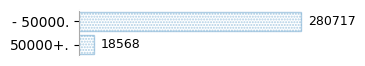

In [13]:
target = 'target'
_ = describe(data[target], 'cat')

<a id="acc-naive"></a>We can clearly see that the target variable takes only two values (levels of income). Thus, we will be solving a binary classification problem in this task. Let's encode the target variable as `1` and `0` for the further analysis. Don't forget to check that the encoding is done correctly.

Shape: (299285,)
Data type: int32
2 unique
0 nulls
--------------------


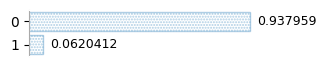

In [14]:
target_label_enc = LabelEncoder()
data[target] = target_label_enc.fit_transform(data[target])
_ = describe(data[target], 'cat', normalize=True)

Note, the distribution of the target is not uniform, i.e. we have highly imbalanced data: $\approx$ 93.8% (majority class) vs $\approx$ 6.2% (minority class) observations $\approx$ 15:1 ratio. Therefore, we __cannot use__ the `accuracy score` to evaluate our classifier(s) without dealing with imbalance, since it makes no sense. Indeed, let's build a dummy classifier that will always predict the most frequent level of income which is 0 (- 50000.), and compute the accuracy score for such predictions.

In [15]:
model_dummy = DummyClassifier(strategy='most_frequent', random_state=seed)
y_pred_dummy = model_dummy.fit(data.drop(columns=target), data[target]).predict(data.drop(columns=target))
print(f'Predicted level of income: {y_pred_dummy[:5]} ...')
print(f"Dummy classifier's accuracy = {accuracy_score(data[target], y_pred_dummy):.2%}")

Predicted level of income: [0 0 0 0 0] ...
Dummy classifier's accuracy = 93.80%


Is the task solved? Well, if we're only interested in reporting the overall accuracy, which is frequency of the "`- 50000.`" income level in this case, regardless of any other features in our data, then yes. The problem with this classifier is that it cannot predict the minority class at all.

Let predicting the level of income "`- 50000.`" be the no-effect ($\mathcal H_0: \text{Class} = 0$), and predicting the level of income "`50000+.`" be the positive effect ($\mathcal H_1: \text{Class} = 1$). Now, __let's assume that we're interested in correctly reporting the positive effect__ from observing the features of our participants. In other words, we would like to understand the profile of those participants who earn more. Imagine, that this is important because we want to introduce a new extra income tax for individuals who earn more than 50'000. If our classifier falsely reports the positive effect (falsely rejects $\mathcal H_0$, makes type I errors), then individuals who earn less than 50'000 will be subject to this new extra tax burden, which is inappropriate, and thus such outcomes should be avoided. So, __our key metric will be `precision`__ (true positives per predicted as positives). Another scenario might be to find as much as possible those individuals who indeed earn more, for some further analysis. In this case we would focus on `recall` (true positives per real positives). We will also look at `f1 score` and `PR-AUC` to evaluate the balance between precision and recall. Let's assume, that in this task we're not interested in correctly reporting the no-effect, so we will not look at metrics for true negative observations.

---
* 1.2. (8%) Which validation strategy are you going to use and why? Apply it to the data on the preprocessing step

Let's choose the __Stratified K-Fold cross-validation strategy__ applied on the train data. It is a variation of the K-Fold cross-validation [strategy](#val-strategy) that uses stratified folds. This strategy allows to keep proportions of observations selected into folds, as per the target class distribution, thus taking into account the imbalance of our data.

The advantages of this strategy:
- it does not require any additional validation data, since the validation samples are constructed from the train data itself;
- it does not require any preprocessing of the train data, since the folds are created during the very process of cross-validation on the fly.

However, this strategy has disadvantages too:
- since one of the folds is used for validation, not all train data is used for fitting the model in every training round;
- the model (or pipeline) has to be trained as many times as there are folds, which takes time.

This will be our base strategy. Additionally, let's allocate some smaller sample (10%) from our data. This sample might be used for ad hoc validations: to estimate predictions, try techniques, do other calculations. So we will split our data into 3 parts:
- train, used for training and cross-validation of models — 70%;
- val, used for ad hoc validation — 10%;
- test, used for final estimation of models — 20%.

The split will be done in section 3 below.

---
* 1.3. (9%) Explore which features do you have, what is their distribution and connection to the target. Perform feature selection techniques such as PCA, and feature engineering, if necessary. Explain your decisions

Now, let's look closer at our predictors (features).
- for categorical and ordinal features we will check association with the target by using $\chi^2$-test by looking at the test's $p$-value and Cramer's V statistic. For the sake of simplicity and saving time, we'll ignore the $\chi^2$-test's requirement of more than 5 counts in the contingency table cells. Some researchers believe that this requirement might be dropped.
- for numerical features we will check Pearson correlation with the target (linear). However, since the target is binary it does not make much sense to compute the correlation coefficient directly. Instead, we'll use one of disadvantages of the target encoding technique which is target leakage — we will check the correlation between a numerical feature and its target-encoded copy. Since, our numerical features are integers (or they can be binned, anyway), we can divide them in separate "categories" corresponding to their discrete values. Now, target encoding returns the average target value for each "category" of a feature, which is the probability of class 1, in fact. That is, it transforms a feature into the target's probability space (continuos), so we can compute Pearson correlation coefficient.

In [16]:
# All features
data.drop(columns=target).columns

Index(['age', 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household', 'instance weight',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
 

In [17]:
feat_eng_target_enc = TargetEncoder(target_type='binary', random_state=seed)

In [18]:
# These will store our selected features
num_cols, cat_cols = [], []

Pearson corr coef = 0.54
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 90.00
Mean = 34.54
Med = 33.00
Std = 22.32


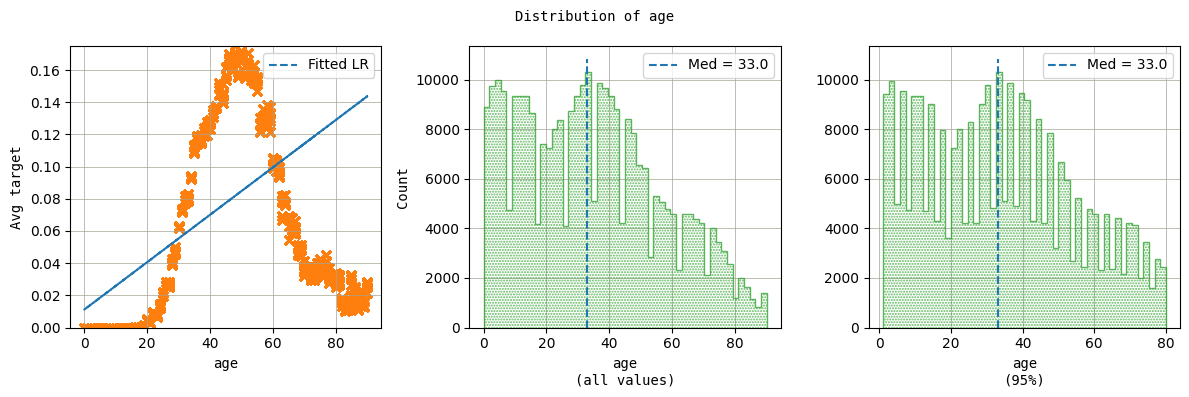

In [19]:
# 1. Age
feature_name = 'age'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

`age` looks like a continuous variable. Middle-aged participants earn more than younger and older ones. We will keep this feature so far.

In [20]:
num_cols.append(feature_name)

Shape: (299285,)
Data type: object
9 unique
0 nulls
--------------------


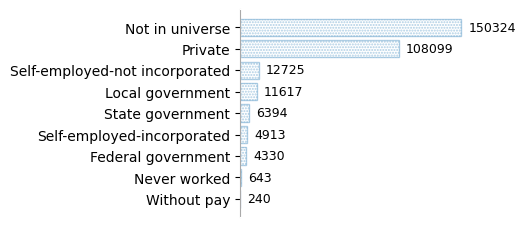

In [21]:
# 2. Class of worker
feature_name = 'class of worker'
_ = describe(data[feature_name], 'cat')

In [22]:
_ = run_chi2test(data[feature_name], data[target])

target                  0     1
class of worker                
Federal government   3459   871
Local government    10332  1285
...                   ...   ...
State government     5646   748
Without pay           238     2
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2591
`class of worker` and `target` are _not_ independent


We have confirmed that `class of worker` and target are not independent indeed, thus we will keep this feature so far.

In [23]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

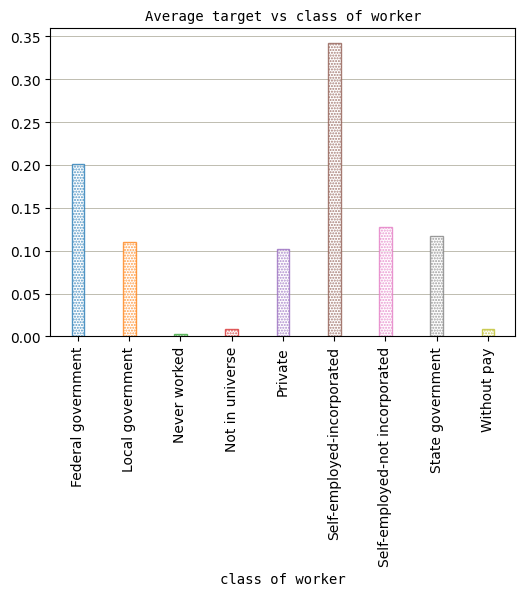

In [24]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=90)

Self-employed-incorporated category is the leader. Lawyers?

Shape: (299285,)
Data type: int64
52 unique
0 nulls
--------------------


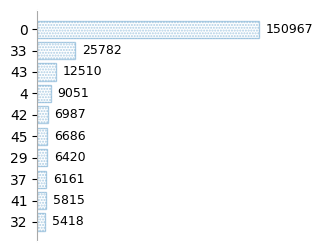

In [25]:
# 3. Detailed industry recode
feature_name = 'detailed industry recode'
_ = describe(data[feature_name], 'cat')

In [26]:
_ = run_chi2test(data[feature_name], data[target])

target                         0     1
detailed industry recode              
0                         149616  1351
1                           1137    71
...                          ...   ...
50                          2089   436
51                            43     9
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2931
`detailed industry recode` and `target` are _not_ independent


We have confirmed that `detailed industry recode` and target are not independent indeed, thus we will keep this feature so far.

In [27]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: int64
47 unique
0 nulls
--------------------


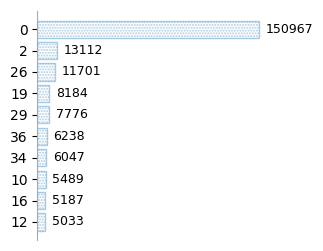

In [28]:
# 4. Detailed occupation recode
feature_name = 'detailed occupation recode'
_ = describe(data[feature_name], 'cat')

In [29]:
_ = run_chi2test(data[feature_name], data[target])

target                           0     1
detailed occupation recode              
0                           149616  1351
1                              617   203
...                            ...   ...
45                             226    26
46                              43     9
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.4380
`detailed occupation recode` and `target` are _not_ independent


We have confirmed that `detailed occupation recode` and target are not independent indeed, thus we will keep this feature so far.

In [30]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
17 unique
0 nulls
--------------------


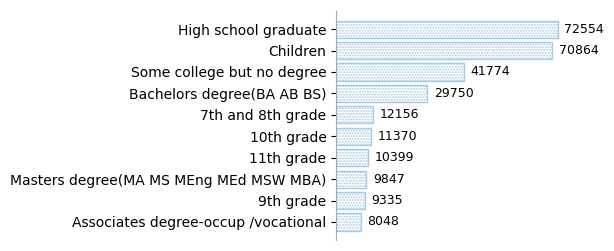

In [31]:
# 5. Education
feature_name = 'education'
_ = describe(data[feature_name], 'cat')

In [32]:
_ = run_chi2test(data[feature_name], data[target])

target                                      0     1
education                                          
10th grade                              11274    96
11th grade                              10283   116
...                                       ...   ...
Prof school degree (MD DDS DVM LLB JD)   1222  1447
Some college but no degree              39145  2629
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.3895
`education` and `target` are _not_ independent


We have confirmed that `education` and target are not independent indeed, thus we will keep this feature so far.

In [33]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

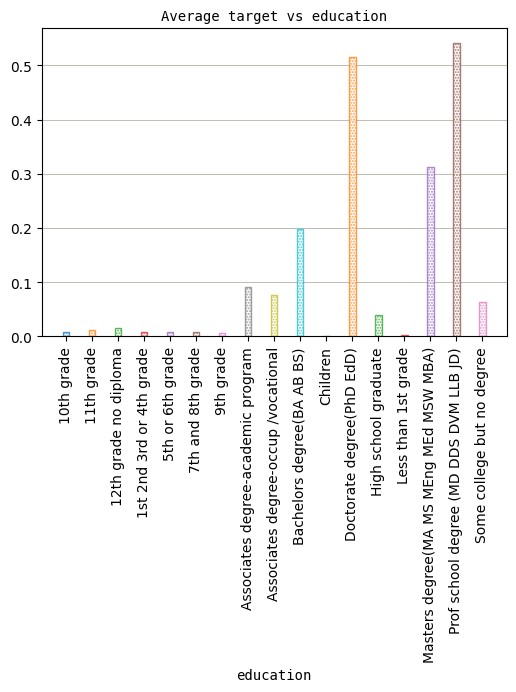

In [34]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=90)

No wonder, that participants with doctorate, masters and professional school degrees earn more.

Pearson corr coef = 0.09
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 9,999.00
Mean = 55.11
Med = 0.00
Std = 273.34


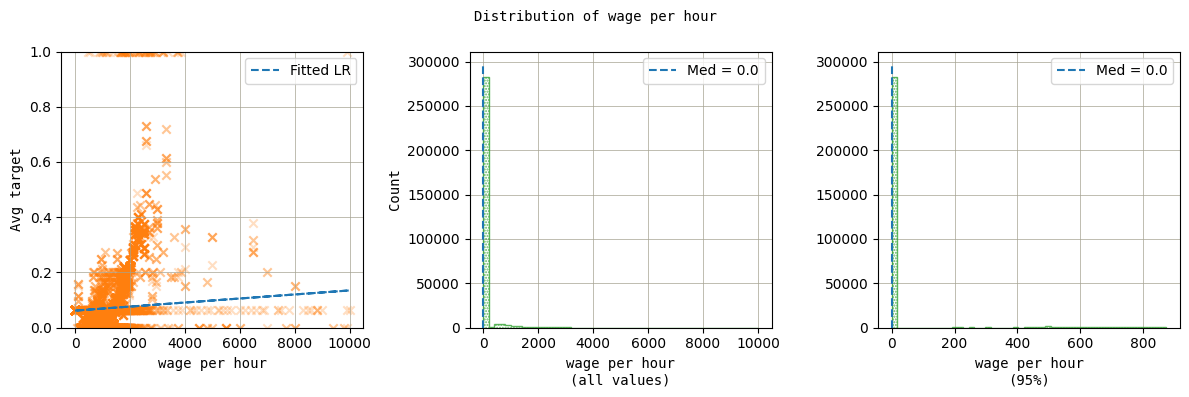

In [35]:
# 6. Wage per hour
feature_name = 'wage per hour'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Shape: (299285,)
Data type: int64
1425 unique
0 nulls
--------------------


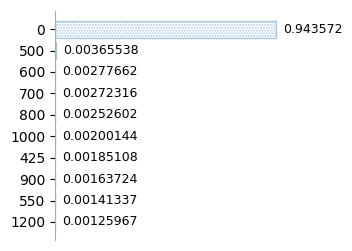

In [36]:
_ = describe(data[feature_name], 'cat', normalize=True)

`wage per hour` looks like a continuous variable. It has over 94% of the same value of 0.0, that is the feature does not variate much. Also it is very loosely linearly correlated with the target, thus we will not use it in our model.

Shape: (299285,)
Data type: object
3 unique
0 nulls
--------------------


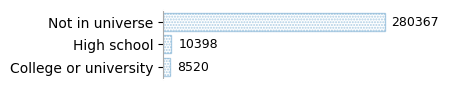

In [37]:
# 7. Enroll in edu inst last wk
feature_name = 'enroll in edu inst last wk'
_ = describe(data[feature_name], 'cat')

In [38]:
_ = run_chi2test(data[feature_name], data[target])

target                           0      1
enroll in edu inst last wk               
College or university         8485     35
High school                  10393      5
Not in universe             261839  18528
--------------------
p_value = 1.40e-271 (alpha = 0.05)
cramer_v = 0.0646
`enroll in edu inst last wk` and `target` are _not_ independent


We have confirmed that `enroll in edu inst last wk` and target are not independent indeed, thus we will keep this feature so far. Interestingly, there are high school students who earn more than 50,000.

In [39]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
7 unique
0 nulls
--------------------


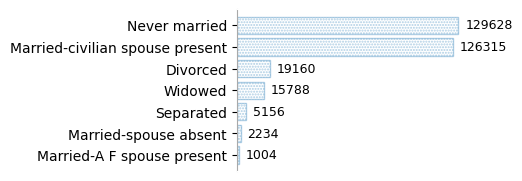

In [40]:
# 8. Marital stat
feature_name = 'marital stat'
_ = describe(data[feature_name], 'cat')

In [41]:
_ = run_chi2test(data[feature_name], data[target])

target                          0     1
marital stat                           
Divorced                    17596  1564
Married-A F spouse present    983    21
...                           ...   ...
Separated                    4927   229
Widowed                     15270   518
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.1981
`marital stat` and `target` are _not_ independent


We have confirmed that `marital stat` and target are not independent indeed, thus we will keep this feature so far.

In [42]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

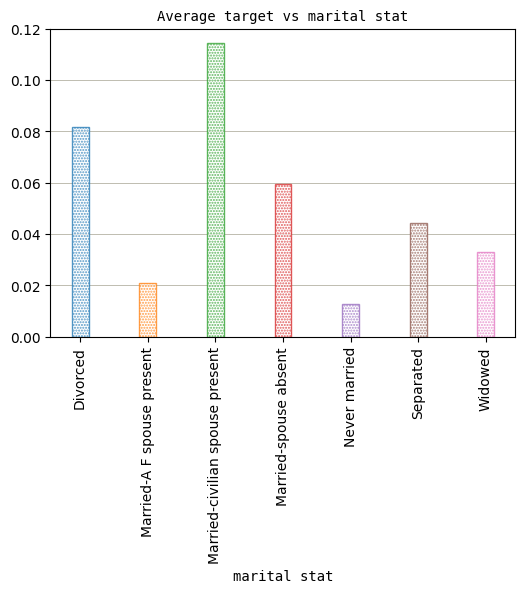

In [43]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=90)

Married-civilian spouse present is the leader.

Shape: (299285,)
Data type: object
24 unique
0 nulls
--------------------


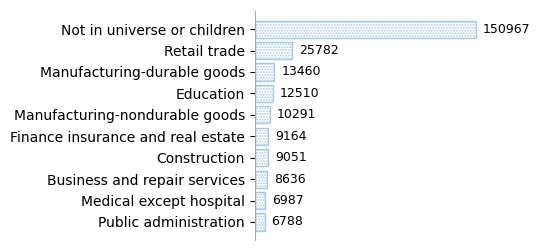

In [44]:
# 9. Major industry code
feature_name = 'major industry code'
_ = describe(data[feature_name], 'cat')

In [45]:
_ = run_chi2test(data[feature_name], data[target])

target                              0    1
major industry code                       
Agriculture                      4218  263
Armed Forces                       43    9
...                               ...  ...
Utilities and sanitary services  1354  394
Wholesale trade                  4575  843
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2789
`major industry code` and `target` are _not_ independent


We have confirmed that `major industry code` and target are not independent indeed, thus we will keep this feature so far.

In [46]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
15 unique
0 nulls
--------------------


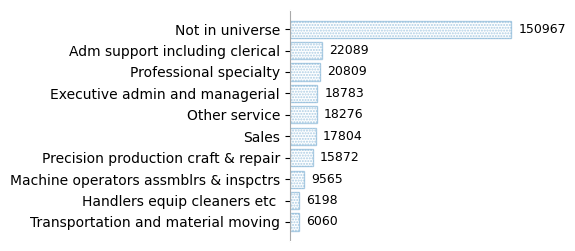

In [47]:
# 10. Major occupation code
feature_name = 'major occupation code'
_ = describe(data[feature_name], 'cat')

In [48]:
_ = run_chi2test(data[feature_name], data[target])

target                                  0    1
major occupation code                         
Adm support including clerical      21410  679
Armed Forces                           43    9
...                                   ...  ...
Technicians and related support      3973  517
Transportation and material moving   5641  419
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.3663
`major occupation code` and `target` are _not_ independent


We have confirmed that `major occupation code` and target are not independent indeed, thus we will keep this feature so far.

In [49]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

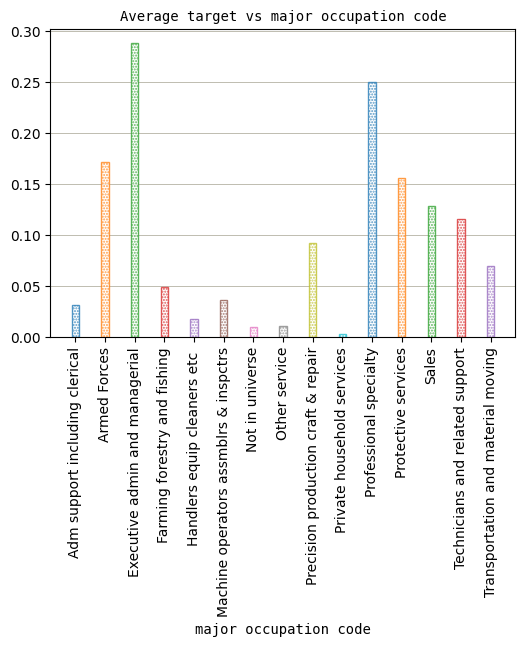

In [50]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=90)

No surprise, managerial category is the leader.

Shape: (299285,)
Data type: object
5 unique
0 nulls
--------------------


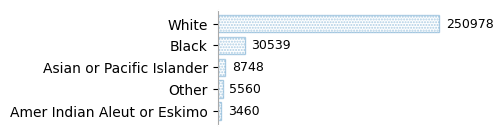

In [51]:
# 11. Race
feature_name = 'race'
_ = describe(data[feature_name], 'cat')

In [52]:
_ = run_chi2test(data[feature_name], data[target])

target                            0      1
race                                      
Amer Indian Aleut or Eskimo    3383     77
Asian or Pacific Islander      8121    627
Black                         29722    817
Other                          5434    126
White                        234057  16921
--------------------
p_value = 1.16e-222 (alpha = 0.05)
cramer_v = 0.0588
`race` and `target` are _not_ independent


We have confirmed that `race` and target are not independent indeed, thus we will keep this feature so far.

In [53]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
9 unique
1279 nulls
--------------------


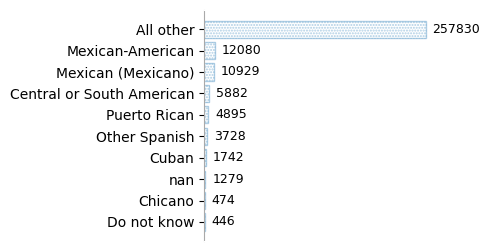

In [54]:
# 12. Hispanic origin
feature_name = 'hispanic origin'
_ = describe(data[feature_name], 'cat')

In [55]:
_ = run_chi2test(data[feature_name], data[target])

target                          0      1
hispanic origin                         
All other                  240206  17624
Central or South American    5755    127
...                           ...    ...
Puerto Rican                 4790    105
NaN                          1206     73
--------------------
p_value = 1.60e-289 (alpha = 0.05)
cramer_v = 0.0677
`hispanic origin` and `target` are _not_ independent


We have confirmed that `hispanic origin` and target are not independent indeed, thus we will keep this feature so far.

In [56]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
2 unique
0 nulls
--------------------


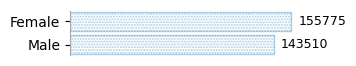

In [57]:
# 13. Sex
feature_name = 'sex'
_ = describe(data[feature_name], 'cat')

In [58]:
_ = run_chi2test(data[feature_name], data[target])

target       0      1
sex                  
Female  151807   3968
Male    128910  14600
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.1579
`sex` and `target` are _not_ independent


We have confirmed that `sex` and target are not independent indeed, thus we will keep this feature so far. Interestingly, men look to earn more than women.

In [59]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

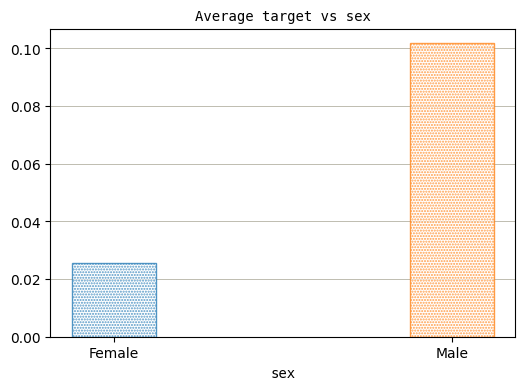

In [60]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=0)

No comments!

Shape: (299285,)
Data type: object
3 unique
0 nulls
--------------------


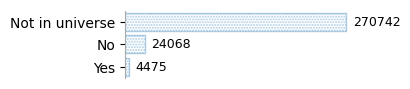

In [61]:
# 14. Member of a labor union
feature_name = 'member of a labor union'
_ = describe(data[feature_name], 'cat')

In [62]:
_ = run_chi2test(data[feature_name], data[target])

target                        0      1
member of a labor union               
No                        21356   2712
Not in universe          255499  15243
Yes                        3862    613
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.0742
`member of a labor union` and `target` are _not_ independent


We have confirmed that `member of a labor union` and target are not independent indeed, thus we will keep this feature so far.

In [63]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
6 unique
0 nulls
--------------------


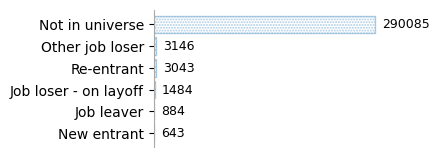

In [64]:
# 15. Reason for unemployment
feature_name = 'reason for unemployment'
_ = describe(data[feature_name], 'cat')

In [65]:
_ = run_chi2test(data[feature_name], data[target])

target                      0    1
reason for unemployment           
Job leaver                853   31
Job loser - on layoff    1448   36
...                       ...  ...
Other job loser          2986  160
Re-entrant               3015   28
--------------------
p_value = 8.63e-51 (alpha = 0.05)
cramer_v = 0.0286
`reason for unemployment` and `target` are _not_ independent


We have confirmed that `reason for unemployment` and target are not independent indeed, thus we will keep this feature so far.

In [66]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
8 unique
0 nulls
--------------------


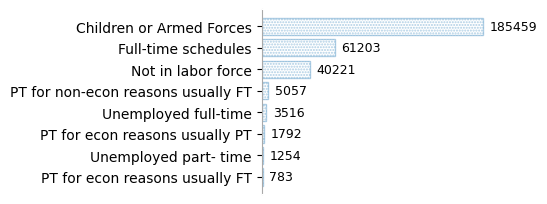

In [67]:
# 16. Full or part time employment stat
feature_name = 'full or part time employment stat'
_ = describe(data[feature_name], 'cat')

In [68]:
_ = run_chi2test(data[feature_name], data[target])

target                                  0     1
full or part time employment stat              
Children or Armed Forces           176707  8752
Full-time schedules                 53121  8082
...                                   ...   ...
Unemployed full-time                 3390   126
Unemployed part- time                1224    30
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.1604
`full or part time employment stat` and `target` are _not_ independent


We have confirmed that `full or part time employment stat` and target are not independent indeed, thus we will keep this feature so far.

In [69]:
cat_cols.append(feature_name)

Let's also look at how the average target depends on this feature. We'll use the same trick as with age to transform the feature into the target's probability space.

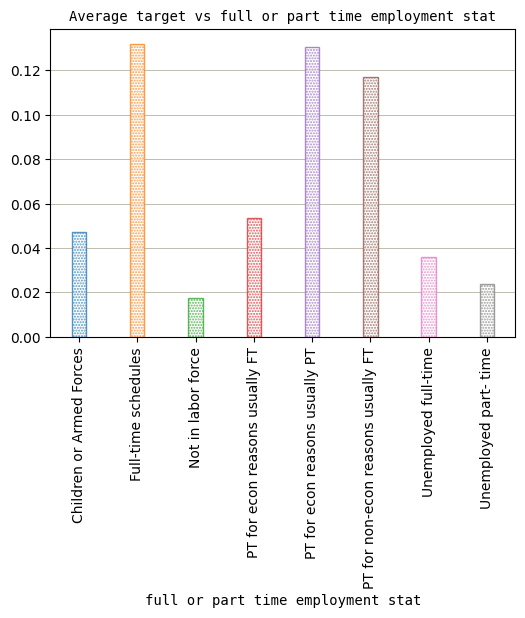

In [70]:
_ = pd.concat([pd.Series(feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target]).squeeze(), name=f'{feature_name}_encoded'), data[feature_name]], axis=1)
_ = pd.DataFrame(_.groupby(feature_name)[f'{feature_name}_encoded'].mean()).reset_index()
plot_bar(_, feature_name, f'{feature_name}_encoded', xlabel=feature_name, title=f'Average target vs {feature_name}', rot=90)

No clear leader: both full-timers and part-timers earn more than unemployed — what a surprise!

Pearson corr coef = 0.65
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 99,999.00
Mean = 431.74
Med = 0.00
Std = 4,670.77


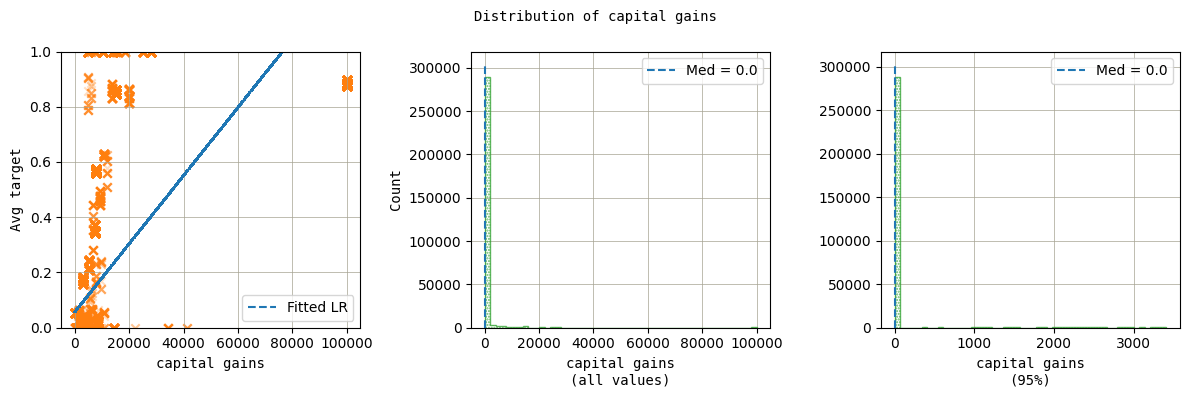

In [71]:
# 17. Capital gains
feature_name = 'capital gains'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Shape: (299285,)
Data type: int64
133 unique
0 nulls
--------------------


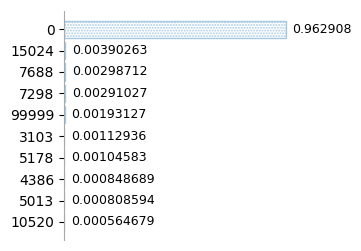

In [72]:
_ = describe(data[feature_name], 'cat', normalize=True)

`capital gains` looks like a continuous variable. It has over 96% of the same value of 0.0, that is the feature does not variate much, but still it's linearly correlated with the target, thus we will keep this feature so far.

In [73]:
num_cols.append(feature_name)

Pearson corr coef = 0.59
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 4,608.00
Mean = 36.85
Med = 0.00
Std = 269.79


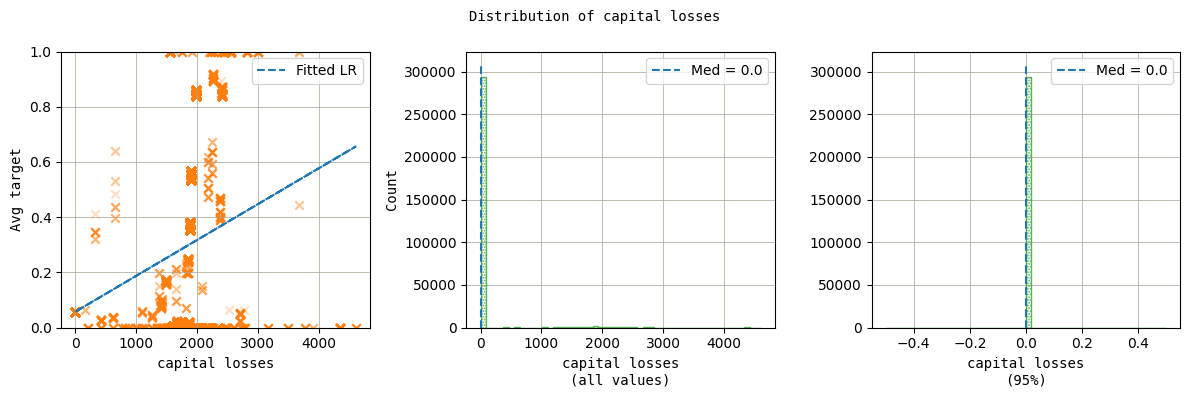

In [74]:
# 18. Capital losses
feature_name = 'capital losses'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Shape: (299285,)
Data type: int64
114 unique
0 nulls
--------------------


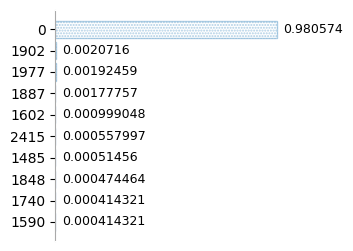

In [75]:
_ = describe(data[feature_name], 'cat', normalize=True)

`capital losses` looks like a continuous variable. It has over 98% of the same value of 0.0, that is the feature does not variate much, but still it's linearly correlated with the target, thus we will keep this feature so far.

In [76]:
num_cols.append(feature_name)

Pearson corr coef = 0.51
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 99,999.00
Mean = 195.85
Med = 0.00
Std = 1,937.85


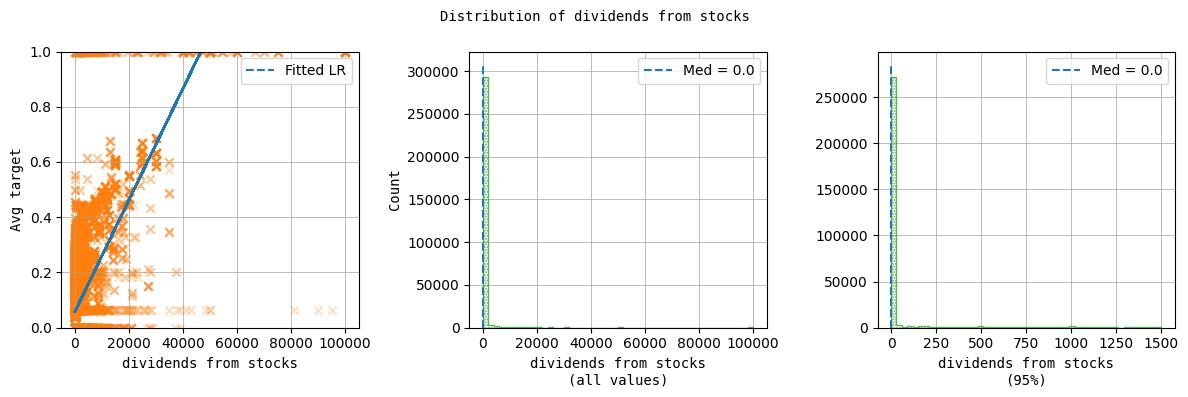

In [77]:
# 19. Dividends from stocks
feature_name = 'dividends from stocks'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Shape: (299285,)
Data type: int64
1675 unique
0 nulls
--------------------


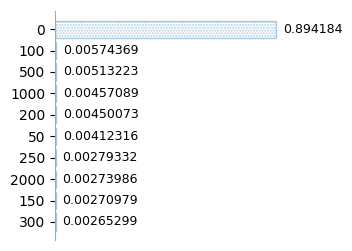

In [78]:
_ = describe(data[feature_name], 'cat', normalize=True)

`dividends from stocks` looks like a continuous variable. It has over 89% of the same value of 0.0, that is the feature does not variate much, but still it's linearly correlated with the target, thus we will keep this feature so far.

In [79]:
num_cols.append(feature_name)

Shape: (299285,)
Data type: object
6 unique
0 nulls
--------------------


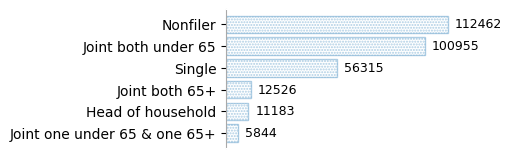

In [80]:
# 20. Tax filer stat
feature_name = 'tax filer stat'
_ = describe(data[feature_name], 'cat')

In [81]:
_ = run_chi2test(data[feature_name], data[target])

target                  0     1
tax filer stat                 
Head of household   10521   662
Joint both 65+      11870   656
...                   ...   ...
Nonfiler           112412    50
Single              52903  3412
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2302
`tax filer stat` and `target` are _not_ independent


We have confirmed that `tax filer stat` and target are not independent indeed, thus we will keep this feature so far.

In [82]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
6 unique
0 nulls
--------------------


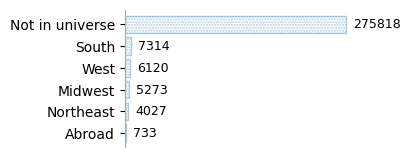

In [83]:
# 21. Region of previous residence
feature_name = 'region of previous residence'
_ = describe(data[feature_name], 'cat')

In [84]:
_ = run_chi2test(data[feature_name], data[target])

target                           0    1
region of previous residence           
Abroad                         707   26
Midwest                       5103  170
...                            ...  ...
South                         7048  266
West                          5867  253
--------------------
p_value = 1.01e-48 (alpha = 0.05)
cramer_v = 0.0280
`region of previous residence` and `target` are _not_ independent


We have confirmed that `region of previous residence` and target are not independent indeed, thus we will keep this feature so far.

In [85]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
50 unique
1038 nulls
--------------------


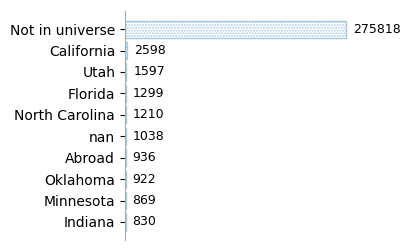

In [86]:
# 22. State of previous residence
feature_name = 'state of previous residence'
_ = describe(data[feature_name], 'cat')

In [87]:
_ = run_chi2test(data[feature_name], data[target])

target                         0   1
state of previous residence         
Abroad                       904  32
Alabama                      315   9
...                          ...  ..
Wyoming                      161   6
NaN                          333  11
--------------------
p_value = 3.28e-37 (alpha = 0.05)
cramer_v = 0.0316
`state of previous residence` and `target` are _not_ independent


We have confirmed that `state of previous residence` and target are not independent indeed, thus we will keep this feature so far.

In [88]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
38 unique
0 nulls
--------------------


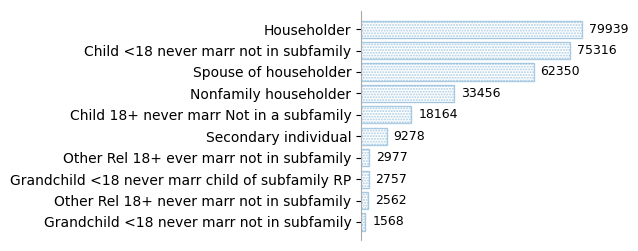

In [89]:
# 23. Detailed household and family stat
feature_name = 'detailed household and family stat'
_ = describe(data[feature_name], 'cat')

In [90]:
_ = run_chi2test(data[feature_name], data[target])

target                                      0     1
detailed household and family stat                 
Child 18+ ever marr Not in a subfamily   1441    37
Child 18+ ever marr RP of subfamily      1005    20
...                                       ...   ...
Spouse of RP of unrelated subfamily        69     7
Spouse of householder                   58922  3428
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2406
`detailed household and family stat` and `target` are _not_ independent


We have confirmed that `detailed household and family stat` and target are not independent indeed, thus we will keep this feature so far.

In [91]:
cat_cols.append(feature_name)

In [92]:
# 24. Detailed household summary in household
feature_name = 'detailed household summary in household'
_ = describe(data[feature_name], 'cat')

Shape: (299285,)
Data type: object
8 unique
0 nulls
--------------------


In [93]:
_ = run_chi2test(data[feature_name], data[target])

target                                       0     1
detailed household summary in household             
Child 18 or older                        21585   184
Child under 18 ever married                 69     0
...                                        ...   ...
Other relative of householder            14400   133
Spouse of householder                    58938  3428
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2267
`detailed household summary in household` and `target` are _not_ independent


We have confirmed that `detailed household summary in household` and target are not independent indeed, thus we will keep this feature so far.

In [94]:
cat_cols.append(feature_name)

Pearson corr coef = 0.03
Shape: (299285,)
Data type: float64
0 nulls
Min = 37.87
Max = 18,656.30
Mean = 1,740.10
Med = 1,617.11
Std = 994.14


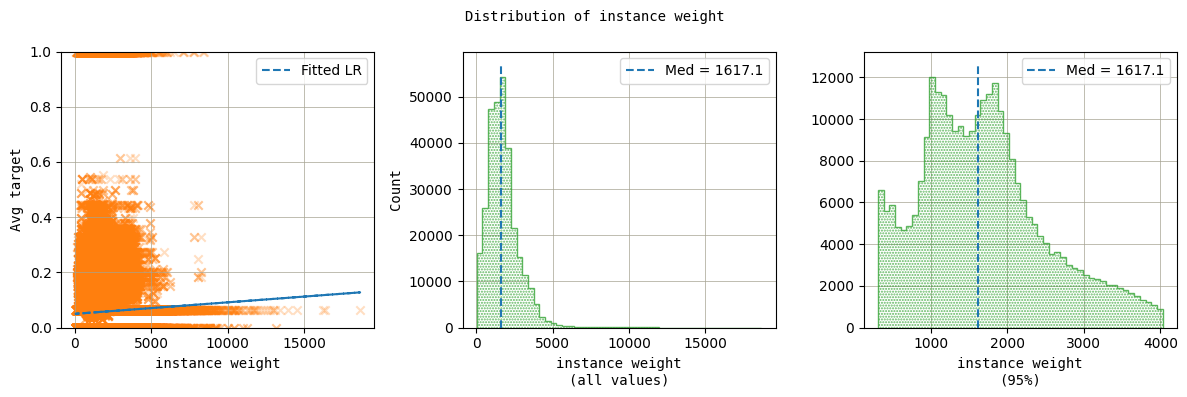

In [95]:
# 25. Instance weight
feature_name = 'instance weight'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

`instance weight` looks like a continuous variable. Note that as per the description of this dataset (census-income.names), this variable should _not_ be used in the classifiers, thus we will drop and not use this feature in our model.

In [96]:
data.drop(columns=feature_name, inplace=True)

Shape: (299285,)
Data type: object
9 unique
149642 nulls
--------------------


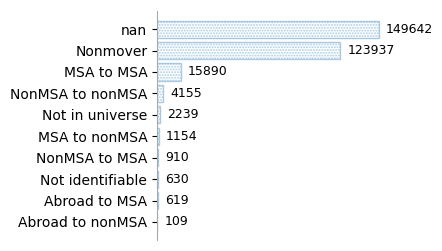

In [97]:
# 26. Migration code-change in msa
feature_name = 'migration code-change in msa'
_ = describe(data[feature_name], 'cat')

In [98]:
_ = run_chi2test(data[feature_name], data[target])

target                             0     1
migration code-change in msa              
Abroad to MSA                    595    24
Abroad to nonMSA                 107     2
...                              ...   ...
Not in universe                 2239     0
NaN                           139772  9870
--------------------
p_value = 2.06e-86 (alpha = 0.05)
cramer_v = 0.0378
`migration code-change in msa` and `target` are _not_ independent


We have confirmed that `migration code-change in msa` and target are not independent indeed, thus we will keep this feature so far. Note that this feature has around 50% of missing values.

In [99]:
cat_cols.append(feature_name)

In [100]:
# 27. Migration code-change in reg
feature_name = 'migration code-change in reg'
_ = describe(data[feature_name], 'cat')

Shape: (299285,)
Data type: object
8 unique
149642 nulls
--------------------


In [101]:
_ = run_chi2test(data[feature_name], data[target])

target                             0     1
migration code-change in reg              
Abroad                           707    26
Different county same state     3924   202
...                              ...   ...
Same county                    14185   506
NaN                           139772  9870
--------------------
p_value = 3.85e-83 (alpha = 0.05)
cramer_v = 0.0369
`migration code-change in reg` and `target` are _not_ independent


We have confirmed that `migration code-change in reg` and target are not independent indeed, thus we will keep this feature so far. Note that this variable has around 50% of missing values.

In [102]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
9 unique
149642 nulls
--------------------


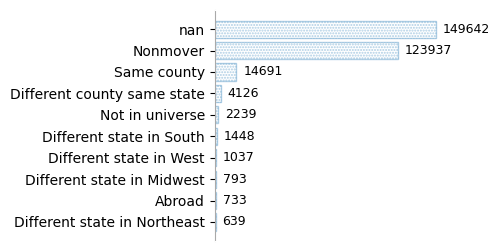

In [103]:
# 28. Migration code-move within reg
feature_name = 'migration code-move within reg'
_ = describe(data[feature_name], 'cat')

In [104]:
_ = run_chi2test(data[feature_name], data[target])

target                               0     1
migration code-move within reg              
Abroad                             707    26
Different county same state       3924   202
...                                ...   ...
Same county                      14185   506
NaN                             139772  9870
--------------------
p_value = 1.34e-83 (alpha = 0.05)
cramer_v = 0.0372
`migration code-move within reg` and `target` are _not_ independent


We have confirmed that `migration code-move within reg` and target are not independent indeed, thus we will keep this feature so far. Note that this feature has around 50% of missing values.

In [105]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
3 unique
0 nulls
--------------------


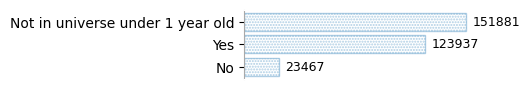

In [106]:
# 29. Live in this house 1 year ago
feature_name = 'live in this house 1 year ago'
_ = describe(data[feature_name], 'cat')

In [107]:
_ = run_chi2test(data[feature_name], data[target])

target                                 0     1
live in this house 1 year ago                 
No                                 22520   947
Not in universe under 1 year old  142011  9870
Yes                               116186  7751
--------------------
p_value = 6.15e-47 (alpha = 0.05)
cramer_v = 0.0267
`live in this house 1 year ago` and `target` are _not_ independent


We have confirmed that `live in this house 1 year ago` and target are not independent indeed, thus we will keep this feature so far.

In [108]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
3 unique
149642 nulls
--------------------


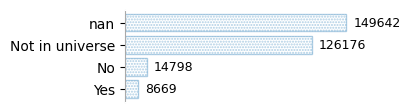

In [109]:
# 30. Migration prev res in sunbelt
feature_name = 'migration prev res in sunbelt'
_ = describe(data[feature_name], 'cat')

In [110]:
_ = run_chi2test(data[feature_name], data[target])

target                              0     1
migration prev res in sunbelt              
No                              14146   652
Not in universe                118425  7751
Yes                            139772  9870
NaN                              8374   295
--------------------
p_value = 1.31e-51 (alpha = 0.05)
cramer_v = 0.0283
`migration prev res in sunbelt` and `target` are _not_ independent


We have confirmed that `migration prev res in sunbelt` and target are not independent indeed, thus we will keep this feature so far. Note that this variable has around 50% of missing values.

In [111]:
cat_cols.append(feature_name)

Pearson corr coef = 0.94
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 6.00
Mean = 1.96
Med = 1.00
Std = 2.36


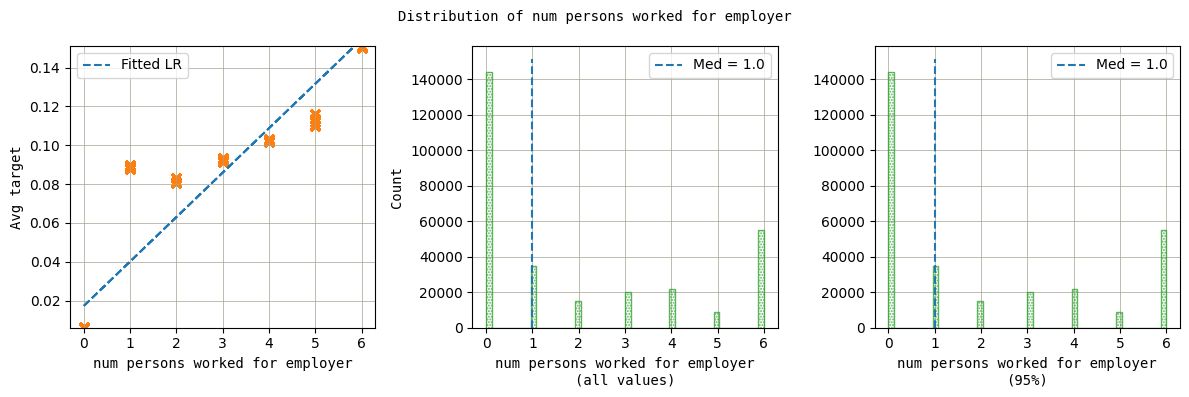

In [112]:
# 31. Num persons worked for employer
feature_name = 'num persons worked for employer'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

`num persons worked for employer` looks like a continuous variable but with few unique integer values. It looks to be strongly correlated with the target (linearly). Since it has a countable number of values (like categories), we can also check if it is associated with the target.

Shape: (299285,)
Data type: int64
7 unique
0 nulls
--------------------


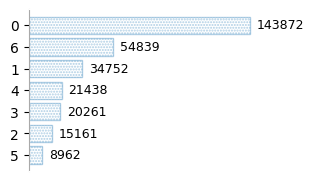

In [113]:
_ = describe(data[feature_name], 'cat')

In [114]:
_ = run_chi2test(data[feature_name], data[target])

target                                0     1
num persons worked for employer              
0                                142966   906
1                                 31666  3086
...                                 ...   ...
5                                  7954  1008
6                                 46574  8265
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.2379
`num persons worked for employer` and `target` are _not_ independent


We have confirmed that `num persons worked for employer` and target are not independent indeed, thus we will keep this feature so far.

In [115]:
num_cols.append(feature_name)

Shape: (299285,)
Data type: object
5 unique
0 nulls
--------------------


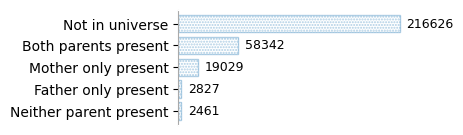

In [116]:
# 32. Family members under 18
feature_name = 'family members under 18'
_ = describe(data[feature_name], 'cat')

In [117]:
_ = run_chi2test(data[feature_name], data[target])

target                        0      1
family members under 18               
Both parents present      58340      2
Father only present        2827      0
Mother only present       19029      0
Neither parent present     2461      0
Not in universe          198060  18566
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.1588
`family members under 18` and `target` are _not_ independent


We have confirmed that `family members under 18` and target are not independent indeed, thus we will keep this feature so far.

In [118]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
42 unique
10142 nulls
--------------------


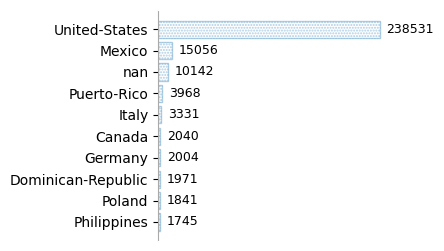

In [119]:
# 33. Country of birth father
feature_name = 'country of birth father'
_ = describe(data[feature_name], 'cat')

In [120]:
_ = run_chi2test(data[feature_name], data[target])

target                      0    1
country of birth father           
Cambodia                  306    7
Canada                   1848  192
...                       ...  ...
Yugoslavia                661   14
NaN                       319   21
--------------------
p_value = 3.20e-295 (alpha = 0.05)
cramer_v = 0.0717
`country of birth father` and `target` are _not_ independent


We have confirmed that `country of birth father` and target are not independent indeed, thus we will keep this feature so far.

In [121]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
42 unique
9191 nulls
--------------------


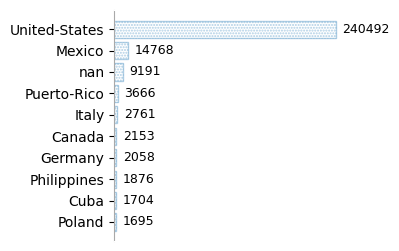

In [122]:
# 34. Country of birth mother
feature_name = 'country of birth mother'
_ = describe(data[feature_name], 'cat')

In [123]:
_ = run_chi2test(data[feature_name], data[target])

target                      0    1
country of birth mother           
Cambodia                  250    8
Canada                   1943  210
...                       ...  ...
Yugoslavia                696   14
NaN                       266   13
--------------------
p_value = 1.41e-285 (alpha = 0.05)
cramer_v = 0.0706
`country of birth mother` and `target` are _not_ independent


We have confirmed that `country of birth mother` and target are not independent indeed, thus we will keep this feature so far.

In [124]:
cat_cols.append(feature_name)

In [125]:
# 35. Country of birth self
feature_name = 'country of birth self'
_ = describe(data[feature_name], 'cat')

Shape: (299285,)
Data type: object
42 unique
5157 nulls
--------------------


In [126]:
_ = run_chi2test(data[feature_name], data[target])

target                   0    1
country of birth self          
Cambodia               156    2
Canada                 943  103
...                    ...  ...
Yugoslavia             559   14
NaN                    108    6
--------------------
p_value = 5.63e-197 (alpha = 0.05)
cramer_v = 0.0598
`country of birth self` and `target` are _not_ independent


We have confirmed that `country of birth self` and target are not independent indeed, thus we will keep this feature so far.

In [127]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: object
5 unique
0 nulls
--------------------


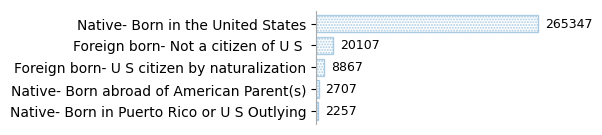

In [128]:
# 36. Citizenship
feature_name = 'citizenship'
_ = describe(data[feature_name], 'cat')

In [129]:
_ = run_chi2test(data[feature_name], data[target])

target                                            0      1
citizenship                                               
Foreign born- Not a citizen of U S            19386    721
Foreign born- U S citizen by naturalization    7968    899
Native- Born abroad of American Parent(s)      2521    186
Native- Born in Puerto Rico or U S Outlying    2204     53
Native- Born in the United States            248638  16709
--------------------
p_value = 8.78e-115 (alpha = 0.05)
cramer_v = 0.0423
`citizenship` and `target` are _not_ independent


We have confirmed that `citizenship` and target are not independent indeed, thus we will keep this feature so far.

In [130]:
cat_cols.append(feature_name)

In [131]:
# 37. Own business or self employed
feature_name = 'own business or self employed'
_ = describe(data[feature_name], 'cat')

Shape: (299285,)
Data type: int64
3 unique
0 nulls
--------------------


In [132]:
_ = run_chi2test(data[feature_name], data[target])

target                              0      1
own business or self employed               
0                              255205  15655
1                                3145    893
2                               22367   2020
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.0822
`own business or self employed` and `target` are _not_ independent


We have confirmed that `own business or self employed` and target are not independent indeed, thus we will keep this feature so far.

In [133]:
cat_cols.append(feature_name)

In [134]:
# 38. Fill inc questionnaire for veteran admin
feature_name = 'fill inc questionnaire for veteran admin'
_ = describe(data[feature_name], 'cat')

Shape: (299285,)
Data type: object
3 unique
0 nulls
--------------------


In [135]:
_ = run_chi2test(data[feature_name], data[target])

target                                         0      1
fill inc questionnaire for veteran admin               
No                                          2090    331
Not in universe                           278061  18213
Yes                                          566     24
--------------------
p_value = 1.80e-52 (alpha = 0.05)
cramer_v = 0.0282
`fill inc questionnaire for veteran admin` and `target` are _not_ independent


We have confirmed that `fill inc questionnaire for veteran admin` and target are not independent indeed, thus we will keep this feature so far.

In [136]:
cat_cols.append(feature_name)

Shape: (299285,)
Data type: int64
3 unique
0 nulls
--------------------


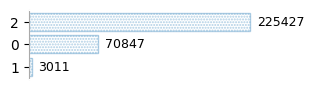

In [137]:
# 39. Veterans benefits
feature_name = 'veterans benefits'
_ = describe(data[feature_name], 'cat')

In [138]:
_ = run_chi2test(data[feature_name], data[target])

target                  0      1
veterans benefits               
0                   70847      0
1                    2656    355
2                  207214  18213
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.1440
`veterans benefits` and `target` are _not_ independent


We have confirmed that `veterans benefits` and target are not independent indeed, thus we will keep this feature so far.

In [139]:
cat_cols.append(feature_name)

In [140]:
# 40. Weeks worked in year
feature_name = 'weeks worked in year'
feature_encoded = feat_eng_target_enc.fit_transform(data[feature_name].values.reshape(-1, 1), data[target])
print(f"Pearson corr coef = {data[feature_name].corr(pd.Series(feature_encoded.flatten())):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, feature_encoded, 50, 95, feature_name, f'Distribution of {feature_name}')

Pearson corr coef = 0.96
Shape: (299285,)
Data type: int64
0 nulls
Min = 0.00
Max = 52.00
Mean = 23.18
Med = 8.00
Std = 24.40


Shape: (299285,)
Data type: int64
53 unique
0 nulls
--------------------


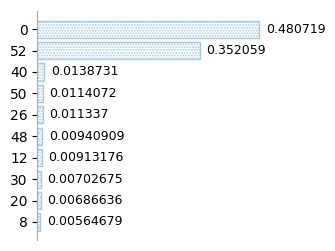

In [141]:
_ = describe(data[feature_name], 'cat', normalize=True)

`weeks worked in year` looks like a continuous variable. It looks to be strongly correlated with the target (linearly). It is mostly takes the values of 0 and 52 weeks. Looks like, those who work more weeks, earn more too. We will keep this feature so far.

In [142]:
num_cols.append(feature_name)

Shape: (299285,)
Data type: int64
2 unique
0 nulls
--------------------


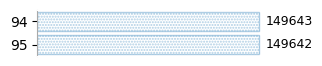

In [143]:
# 41. Year
feature_name = 'year'
_ = describe(data[feature_name], 'cat')

In [144]:
_ = run_chi2test(data[feature_name], data[target])

target       0     1
year                
94      140945  8698
95      139772  9870
--------------------
p_value = 7.07e-19 (alpha = 0.05)
cramer_v = 0.0162
`year` and `target` are _not_ independent


`year` looks like an ordinal/categorical variable which is associated with the target, thus we will keep this feature so far.

In [145]:
cat_cols.append(feature_name)

In [146]:
# EDA done for all features?
# We dropped `instance weight` (num) and did not include `wage per hour` (num).
assert len(num_cols) + len(cat_cols) == data.drop(columns=target).shape[1] - 1, (len(num_cols) + len(cat_cols), data.drop(columns=target).shape[1] - 1)

In [147]:
# Number of features kept so far
print(f'{len(num_cols) = }')
print(f'{len(cat_cols) = }')

len(num_cols) = 6
len(cat_cols) = 33


We have kept 6 out of 7 numerical features. Let's see if we can reduce this number with [PCA](#pca) for 2 components.

In [148]:
pca = PCA(n_components=2, random_state=seed)
num_2d_pc = pca.fit_transform(data[num_cols])
data['pc_1'], data['pc_2'] = num_2d_pc[:, 0], num_2d_pc[:, 1]

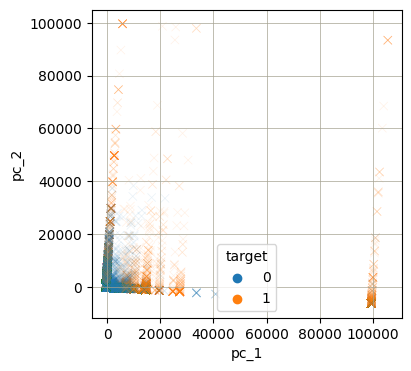

In [149]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data, x='pc_1', y='pc_2', hue=target, marker='x', alpha=0.1)
plt.grid(lw=0.5, color='xkcd:cement');

It looks like the new discovered components can distinguish between the target classes to some degree. Now, let's see if our numerical features, including the new 2 components, correlate between each other (Pearson).

In [150]:
(data[num_cols + ['pc_1', 'pc_2']].corr().replace(1.0, np.nan)
 .style
    .set_caption("<h4>Numerical features correlation matrix (Pearson)</h4>")
    .format(formatter=lambda x: f'{x:.2f}', na_rep='-')
    .highlight_between(
        left=0.5,
        right=1.0,
        color='pink')
    .set_table_styles([
                        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'normal')]},
                        {'selector': 'tbody>tr:hover', 'props': [('background-color', 'lightyellow')]}, # yellow
                        {'selector': 'td:hover', 'props': [('font-weight', 'bold')]}
                        ])
)

We can see that the new feature `pc_1` is strongly linearly correlated with `capital gains` and `pc_2` with `dividends from stocks`, that is adding these two new features does not add new information but only creates colinear covariates, so we will not include new components in our model. At the same time, keeping only these two components will lose information from other features, and the model might underfit. We have only 6 numerical features, so it doesn't look like a dimensionality problem.

 `num persons worked for employer` and `weeks worked in year` look to be correlated. Over 83% of `weeks worked in year` take only two values: 0 and 52, while `num persons worked for employer` variates more, so it's tempting to get rid of the former one. However, let's still keep both for now.

In [151]:
# Final list of numerical features
num_cols

['age',
 'capital gains',
 'capital losses',
 'dividends from stocks',
 'num persons worked for employer',
 'weeks worked in year']

In [152]:
# Num feature-target correlation
feat_target_corr = pd.DataFrame(columns=['num_feature', 'target'])
for num_col in num_cols:
    feature_encoded = feat_eng_target_enc.fit_transform(data[num_col].values.reshape(-1, 1), data[target])
    r = data[num_col].corr(pd.Series(feature_encoded.flatten()))
    feat_target_corr.loc[len(feat_target_corr)] = [num_col, r]

In [153]:
(feat_target_corr.set_index('num_feature')
 .style
    .set_caption("<h4>Numerical features and target correlation matrix (Pearson)</h4>")
    .format(formatter=lambda x: f'{x:.2f}', na_rep='-')
    .highlight_between(
        left=0.5,
        right=1.0,
        color='pink')
    .set_table_styles([
                        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'normal')]},
                        {'selector': 'tbody>tr:hover', 'props': [('background-color', 'lightyellow')]}, # yellow
                        {'selector': 'td:hover', 'props': [('font-weight', 'bold')]}
                        ])
)

Next, we have kept all 33 categorical/ordinal features so far. Let's examine association between them and the target using the Cramer's V metric. We do not use $p$-values for decision-making, because it is not obvious how to weigh them, since they have only one cut-off value at the significance level $\alpha$. Therefore, Cramer's V looks more informative. Tschuprow's T statistic might also be used here.

In [154]:
# Build all categorical/ordinal/target columns associations crosstab
assoc_tab = build_assoc_tab(data, cat_cols + [target])

In [155]:
# Take a look at some 5 random associations
assoc_tab.iloc[sorted(np.random.choice(assoc_tab.shape[0], 5, replace=False))]

X_1                             X_2  \
20               class of worker  migration code-move within reg   
68    detailed occupation recode             major industry code   
321      member of a labor union         country of birth father   
345      reason for unemployment                     citizenship   
410  state of previous residence    migration code-change in msa   

           p_value  cramer_v  
20    0.000000e+00  0.037542  
68    0.000000e+00  0.562944  
321  6.806068e-177  0.042885  
345  1.643753e-108  0.021871  
410   0.000000e+00  0.495963

In [156]:
# We are going to excluded strongly pair-wise associated features
cat_excl_cols = []

In [157]:
# Feature-feature associations
# Do not show target
_ = assoc_tab.loc[lambda x: (x['X_1'] != 'target') & (x['X_2'] != 'target')]
# Exclude `X_2` features with very strong association with `X_1` features (pairs)
# Reference Cramers' V values: https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=terms-cramrs-v
cat_excl_cols.extend(set(_.loc[lambda x: x['cramer_v'] >= 0.8]['X_2'].values))
#cat_excl_cols

In [158]:
# Feature-target associations
# Show only target
_ = assoc_tab.loc[lambda x: (x['X_1'] == 'target') | (x['X_2'] == 'target')]
# Exclude features weakly correlated with the target
cat_excl_cols.extend(set(_.loc[lambda x: x['cramer_v'] < 0.1]['X_1'].values))
#cat_excl_cols

In [159]:
# Final list of categorical features
cat_cols = list(set(cat_cols) - set(cat_excl_cols))
cat_cols

['sex',
 'tax filer stat',
 'class of worker',
 'marital stat',
 'family members under 18',
 'detailed industry recode',
 'detailed occupation recode',
 'education',
 'full or part time employment stat',
 'detailed household and family stat',
 'veterans benefits']

In [160]:
# Check
_ = build_assoc_tab(data, cat_cols + [target]).pivot_table(values='cramer_v', index='X_1', columns='X_2', margins=True)

In [161]:
(_.sort_values(by='All', axis=0, ascending=False).sort_values(by='All', axis=1, ascending=False).drop('All', axis=0).drop('All', axis=1)
.style
    .set_caption("<h4>Features and target association matrix (Cramer's V)</h4>")
    .format(formatter=lambda x: f'{x:.2f}', na_rep='-')
    .set_table_styles([
                        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'normal')]},
                        {'selector': 'tbody>tr:hover', 'props': [('background-color', 'lightyellow')]}, # yellow
                        {'selector': 'td:hover', 'props': [('font-weight', 'bold')]}
                        ])
    .applymap(lambda x: 'background-color: lightgreen', subset='target')
)

Now we can confirm that we excluded strongly associated features between each other ($v \ge 0.8$), while keeping at least some association with the target ($v \ge 0.1$). In the matrix above, "-" means not calculated value, since we used combinations (not permutations) to exclude duplicates and thus speed up, so such values can be found in the corresponding pairs.

Note, that this selection might not be optimal, since we only used the Cramer's V statistic for decision-making without any sorting or other preference between the features. It might be useful to choose the feature that variates more in every pair, like we did with two numerical features above; or compare their association with the target and keep the most associated one in every pair. There is always room for optimization, but it takes time.

Also, for simplicity, we did not check any measure of dependence between numerical and categorical features. This might be done visually using box plots, for example, with distinct categories of a categorical feature on the x-axis and the distribution of a numerical feature on the y-axis. See an example below for age vs education dependence. Males are a bit younger than females on average, but in fact there is no strong dependence, so we can keep both features.

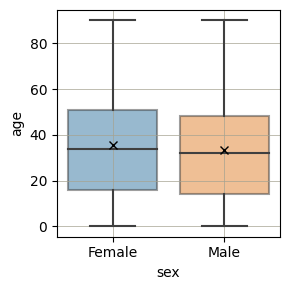

In [162]:
plt.figure(figsize=(3, 3))
sns.boxplot(data=data[['age', 'sex']].sort_values(by='sex'), x='sex', y='age', flierprops={'marker': 'o', 'markersize': 4}, showmeans=True, meanprops={'marker': 'x', 'markeredgecolor': 'k', 'markerfacecolor': 'k', 'markersize': 6}, boxprops=dict(alpha=0.5))
plt.grid(lw=0.5, color='xkcd:cement')
plt.tight_layout();

### <a id="data-preprocessing"></a>[25%] 2. Data preprocessing

* 2.1. (8%) Fill missing values (if there are any)

In [163]:
# Check nulls
data[num_cols + cat_cols + [target]].isna().sum()

age                                   0
capital gains                         0
capital losses                        0
dividends from stocks                 0
num persons worked for employer       0
weeks worked in year                  0
sex                                   0
tax filer stat                        0
class of worker                       0
marital stat                          0
family members under 18               0
detailed industry recode              0
detailed occupation recode            0
education                             0
full or part time employment stat     0
detailed household and family stat    0
veterans benefits                     0
target                                0
dtype: int64

We can see that our data with finally selected features and target does not have missing values, but it is not guaranteed that there will be no missing values in other real data, so we will use imputers both for numerical and categorical features.
- For numerical features, we will impute with the median, since it is a good statistic for central tendency for non-normal skewed distributions. As per feature engineering, no numerical feature has normal distribution;
- For categorical features, we will impute with a constant value 'Unknown'. This value looks reasonable and it does not mutate the original distribution, since we simply substitute empty values (constant) with a non-used new value (another constant).

In [164]:
# Confirm that the 'Unknown' value is not used and thus we can safely use it for imputing
'Unknown' in data[cat_cols].values

False

In [165]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

* 2.2. (9%) Properly encode categorical features. Explain your choice of methods of categorical feature encoding

In [166]:
# Check categorical features cardinality
data[cat_cols].nunique().sort_values(ascending=False)

detailed industry recode              52
detailed occupation recode            47
detailed household and family stat    38
education                             17
class of worker                        9
full or part time employment stat      8
marital stat                           7
tax filer stat                         6
family members under 18                5
veterans benefits                      3
sex                                    2
dtype: int64

<a id="encoding"></a>We will not use one-hot encoding in this task, since several features have high cardinality, and we wouldn't like a too complex model, which is slow to train and subject to overfitting. In general, [feature encoding](#feature-encoding) depends on the model to be used. Consider several classification models:
- Linear models:
1. Logistic Regression needs encoding. Weight of Evidence encoding (WoE) was designed for binary classification. It can be shown that the logit function (result of WoE encoding) is equivalent to the linear regression expression (linear combination of predictors, just like in logistic regression), so it looks to be the proper choice;
- Decision Tree-based models:
2. Random Forest (there's an initiative in sklearn to introduce native support of categorical features) can use ordinal or target-based encoding, preferably with no leakage;
3. XGBoost can use ordinal encoding (pandas category data type), as per documentation, or target-based, preferably with no leakage;
4. LightGBM can use integer-encoding, as per documentation, or target-based, preferably with no leakage;
5. CatBoost natively supports categorical features with built-in CatBoost encoding (target-based with no leakage).

For numerical features for linear algorithms we will also apply standard scaling, since we need to make sure that features (and thus weights) are neither too small, nor too large, so that feature contributions to model's predictions do not either vanish or explode; for decision tree-based algorithms this should not be an issue, so scaling is possible, but not necessary.

In [167]:
num_lm_encoder = StandardScaler()
cat_lm_encoder = WOEEncoder(random_state=seed)
#num_dt_encoder = StandardScaler() # no need
cat_dt_encoder = CatBoostEncoder(random_state=seed)

Now we can construct column transformers tailored to models and feature types.

In [168]:
# Linear models
column_transformer_lm = ColumnTransformer([
                                            ('num_cols', make_pipeline(num_imputer, num_lm_encoder), num_cols), 
                                            ('cat_cols', make_pipeline(cat_imputer, cat_lm_encoder), cat_cols)
                                            ], n_jobs=-1)
# Decision Tree-based models
column_transformer_dt = ColumnTransformer([
                                            ('num_cols', make_pipeline(num_imputer), num_cols), 
                                            ('cat_cols', make_pipeline(cat_imputer, cat_dt_encoder), cat_cols)
                                            ], n_jobs=-1)

In [169]:
# Check, if column transformers work
column_transformer_lm.fit_transform(data[num_cols + cat_cols], data[target])[:1], column_transformer_dt.fit_transform(data[num_cols + cat_cols], data[target])[:1]

(array([[ 1.72328432, -0.09243509, -0.13658439, -0.10106658, -0.82718558,
         -0.94977869, -0.9282956 , -4.98230244, -1.98787383, -0.66600021,
          0.34861754, -1.99068692, -1.99068692, -0.47243045, -1.30188048,
         -1.80700029,  0.28424042]]),
 array([[7.30000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 6.20411982e-02, 6.20411982e-02,
         6.20411982e-02, 6.20411982e-02, 6.20411982e-02, 6.20411982e-02,
         6.20411982e-02, 6.20411982e-02, 6.20411982e-02, 6.20411982e-02,
         6.20411982e-02]]))

* 2.3. (8%) Cluster observations and add cluster number as one of the features. Make sure that the clustering method has a good quality

We'll use [K-Means](#kmeans) clustering algorithm. The algorithm tries to cluster (group) observations, so that the sum of distances from each observation within a cluster to the cluster's center is minimal. For the categorical features clustering algorithms like K-Means or DBSCAN are not applicable, since they use distance metrics, and it's not clear what distance is between, for example, levels of education or marital statuses, so we'll apply clustering to numerical features only. To assess the quality of clustering we'll look at two metrics:
- Inertia (within-cluster sum-of-squares). Inertia decreases as the number of clusters increases. The optimal value is 0.0;
- Silhouette Score (SS) (mean intra-cluster distance). SS also decreases as the number of clusters increases, but the optimal value is 1.0.

The idea is to find the number of clusters such that Inertia is minimized while SS is maximized at the same time: $k_{opt} = \underset{k}{\argmax}(|SS - Inertia|)$.

In [170]:
# Computing silhouette_score is expensive, 
# so we'll take a small random portion of all observations at this stage, 
# but will use the whole data for final clustering, after deciding on the number of clusters.
mean_inertias, mean_ss, n_clusters = [], [], []
for k in range(2, 11):
    inertias, ss = [], []
    #print(k)
    n_clusters.append(k)
    model_kmeans = KMeans(n_clusters=k, n_init='auto', random_state=seed)
    for _ in range(50): # Bootstrap metrics
        idx = np.random.choice(data.shape[0], int(0.01 * data.shape[0]), replace=False)
        labels = model_kmeans.fit(data[num_cols].iloc[idx]).labels_
        inertias.append(model_kmeans.inertia_)
        ss.append(silhouette_score(data[num_cols].iloc[idx], labels))
    mean_inertias.append(np.mean(inertias))
    mean_ss.append(np.mean(ss))

In [171]:
# Inertia and SS are functions of different order, transform them first into [0, 1] codomain, so that we can compare them
inertias_rescaled = MinMaxScaler().fit_transform(np.array(mean_inertias).reshape(-1, 1))
ss_rescaled = MinMaxScaler().fit_transform(np.array(mean_ss).reshape(-1, 1))
k_opt = np.abs(inertias_rescaled - ss_rescaled).argmax() + 2
print(f'Optimal number of clusters: {k_opt}')

Optimal number of clusters: 4


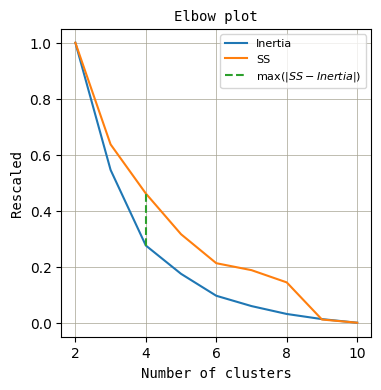

In [172]:
# Elbow plot
plt.figure(figsize=(4, 4))
plt.plot(n_clusters, inertias_rescaled, color='C0', label='Inertia')
plt.plot(n_clusters, ss_rescaled, color='C1', label='SS')
plt.plot([k_opt, k_opt], [inertias_rescaled[k_opt-2], ss_rescaled[k_opt-2]], ls='--', color='C2', label='$\max(|SS-Inertia|)$')
plt.xlabel('Number of clusters', size=10, family='monospace')
plt.ylabel('Rescaled', size=10, family='monospace')
plt.legend(fontsize=8)
plt.title('Elbow plot', size=10, family='monospace')
plt.grid(lw=0.5, color='xkcd:cement');

So, after simultaneously minimizing Inertia and maximizing the Silhouette Score, $k_{opt} \in [4, 6]$. Let's find cluster labels for the optimal number of clusters, and add the clusters' labels as a new feature.

In [173]:
labels = KMeans(n_clusters=k_opt, n_init='auto', random_state=seed).fit(data[num_cols]).labels_
data['group'] = 'Group_'
data['group'] = data['group'] + labels.astype(str)

Let's also quickly check, if our new feature `group` is associated with numerical features. For simplicity, take one feature `age` — some groups intersect by age, which means that there is no strong dependence between the group and age.

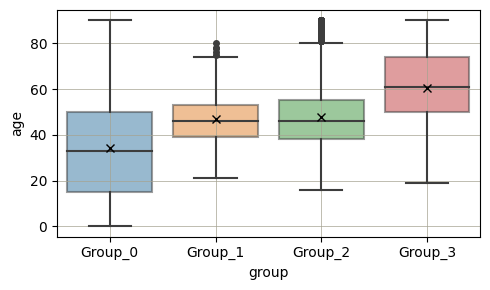

In [174]:
plt.figure(figsize=(5, 3))
sns.boxplot(data=data[['age', 'group']].sort_values(by='group'), x='group', y='age', flierprops={'marker': 'o', 'markersize': 4}, showmeans=True, meanprops={'marker': 'x', 'markeredgecolor': 'k', 'markerfacecolor': 'k', 'markersize': 6}, boxprops=dict(alpha=0.5))
plt.grid(lw=0.5, color='xkcd:cement')
plt.tight_layout();

Also check the association with the target.

Shape: (299285,)
Data type: object
4 unique
0 nulls
--------------------


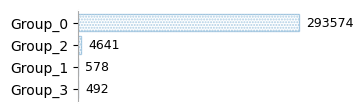

In [175]:
feature_name = 'group'
_ = describe(data[feature_name], 'cat')

In [176]:
_ = run_chi2test(data[feature_name], data[target])

target        0      1
group                 
Group_0  278590  14984
Group_1      65    513
Group_2    1905   2736
Group_3     157    335
--------------------
p_value = 0.00e+00 (alpha = 0.05)
cramer_v = 0.3311
`group` and `target` are _not_ independent


So, we will add the new feature `group` in our model.

In [177]:
cat_cols.append('group')

Final features set (6 num + 12 cat):

|  n | Feature                              | Type |
|---:|--------------------------------------|------|
|  1 | `age`                                | Num  |
|  2 | `capital gains`                      | Num  |
|  3 | `capital losses`                     | Num  |
|  4 | `dividends from stocks`              | Num  |
|  5 | `num persons worked for employer`    | Num  |
|  6 | `weeks worked in year`               | Num  |
|  7 | `class of worker`                    | Cat  |
|  8 | `detailed household and family stat` | Cat  |
|  9 | `detailed industry recode`           | Cat  |
| 10 | `detailed occupation recode`         | Cat  |
| 11 | `education`                          | Cat  |
| 12 | `family members under 18`            | Cat  |
| 13 | `full or part time employment stat`  | Cat  |
| 14 | `group` (added cluster)              | Cat  |
| 15 | `marital stat`                       | Cat  |
| 16 | `sex`                                | Cat  |
| 17 | `tax filer stat`                     | Cat  |
| 18 | `veterans benefits`                  | Cat  |

### <a id="model-training"></a>[25%] 3. Model training

* 3.1. (8%) Apply different techniques which can help to work with imbalanced data. You are supposed to try at least 2 techniques (in the end, you don't have to include them into your final pipeline - but you should explain why)

We can assume that our data is naturally imbalanced — common sense tells use that it is quite expected that there are more individuals who earn less than those who earn more. So we will assume this imbalance is not caused by some incorrect sampling or other bias. Reducing imbalance might help prevent our model from becoming biased towards majority class. In other words, the model will no longer learn only the majority class observations just because they are more frequent. Note that this is only used to train models. It does not make any sense to re-balance our test data, since the imbalance is natural, and real data, fed into models, will always be imbalanced, so the classifier has to learn to work well on real _imbalanced_ data. There are several techniques to [combat imbalance](#handling-imbalance):
- Classifier built-in mechanism tuned by parameters such as "class_weight" — assigned different weights to the majority and minority class observations;
- Undersampling — drop some observations from the majority class:
    - NearMiss;
    - Tomek's links;
    - Random;
- Oversampling — add new observations to the minority class:
    - SMOTE / Borderline SMOTE;
    - ADASYN;
    - Random;
- Combined under- and oversampling:
    - SMOTE + Tomek's links.

First, we'll make the train-val-test split. Don't forget to check that the split and stratification are done correctly.

In [178]:
train, test = train_test_split(data[num_cols + cat_cols + [target]], test_size=0.2, stratify=data[target], random_state=seed)
train, val = train_test_split(train, test_size=0.125, stratify=train[target], random_state=seed)

In [179]:
# Run some split checks
(
    np.allclose(train.shape[0] / data.shape[0], 0.7, atol=1e-6), # Train 70%
    np.allclose(val.shape[0] / data.shape[0], 0.1, atol=1e-6), # Validation 10%
    np.allclose(test.shape[0] / data.shape[0], 0.2, atol=1e-6) # Test 20%
)

(True, True, True)

Shape: (209499,)
Data type: int32
2 unique
0 nulls
--------------------


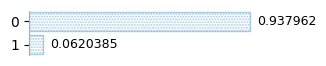

In [180]:
_ = describe(train[target], 'cat', normalize=True)

Shape: (29929,)
Data type: int32
2 unique
0 nulls
--------------------


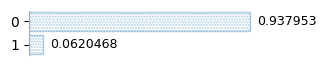

In [181]:
_ = describe(val[target], 'cat', normalize=True)

Shape: (59857,)
Data type: int32
2 unique
0 nulls
--------------------


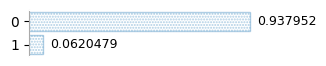

In [182]:
_ = describe(test[target], 'cat', normalize=True)

In [183]:
(
    (train.columns == num_cols + cat_cols + [target]).all(),
    (val.columns == num_cols + cat_cols + [target]).all(), 
    (test.columns == num_cols + cat_cols + [target]).all()
)

(True, True, True)

In [184]:
# Split features and target
y_train = train[target]
y_val = val[target]
y_test = test[target]
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns=target)

In [185]:
(
    (X_train.shape, y_train.shape),
    (X_val.shape, y_val.shape), 
    (X_test.shape, y_test.shape)
)

(((209499, 18), (209499,)), ((29929, 18), (29929,)), ((59857, 18), (59857,)))

Let's use Logistic Regression as our baseline model to evaluate different class balancing techniques. We'll use precision, recall, and $F_{1}$-score (harmonic mean between precision and recall) as the evaluation metrics. We'll use `val` for evaluation.

In [186]:
model_for_balancers = LogisticRegression(random_state=seed, n_jobs=-1)
balancers_to_eval = [{'name': 'None', 'balancer': None},
                     {'name': 'Class-weight', 'balancer': None},
                     {'name': 'RandUnder', 'balancer': RandomUnderSampler(random_state=seed)},
                     {'name': 'NearMiss', 'balancer': NearMiss()},
                     {'name': 'TomekLinks', 'balancer': TomekLinks()},
                     {'name': 'RandOver', 'balancer': RandomOverSampler(random_state=seed)},
                     {'name': 'SMOTE', 'balancer': SMOTE(random_state=seed)},
                     {'name': 'BorderlineSMOTE', 'balancer': BorderlineSMOTE(random_state=seed)},
                     {'name': 'ADASYN', 'balancer': ADASYN(random_state=seed)},
                     {'name': 'SMOTETomek', 'balancer': SMOTETomek(random_state=seed)}
                  ]

In [187]:
for balancer_to_eval in tqdm(balancers_to_eval):
    if balancer_to_eval['name'] == 'Class-weight':
        model = model_for_balancers.set_params(class_weight='balanced')    
    else:
        model = model_for_balancers
    pipe = make_pipeline(column_transformer_lm, balancer_to_eval['balancer'], model)
    y_pred = pipe.fit(X_train, y_train).predict(X_val)
    balancer_to_eval['precision'] = precision_score(y_val, y_pred)
    balancer_to_eval['recall'] = recall_score(y_val, y_pred)
    balancer_to_eval['f1'] = f1_score(y_val, y_pred)

100%|██████████| 10/10 [02:32<00:00, 15.26s/it]


In [188]:
pd.DataFrame(balancers_to_eval).drop(columns='balancer')

name  precision    recall        f1
0             None   0.737939  0.362412  0.486096
1     Class-weight   0.269948  0.889068  0.414148
2        RandUnder   0.268710  0.887453  0.412516
3         NearMiss   0.134311  0.759289  0.228248
4       TomekLinks   0.266613  0.892299  0.410555
5         RandOver   0.269626  0.889607  0.413828
6            SMOTE   0.271287  0.885299  0.415309
7  BorderlineSMOTE   0.261679  0.892838  0.404736
8           ADASYN   0.230419  0.926764  0.369076
9       SMOTETomek   0.270826  0.885837  0.414828

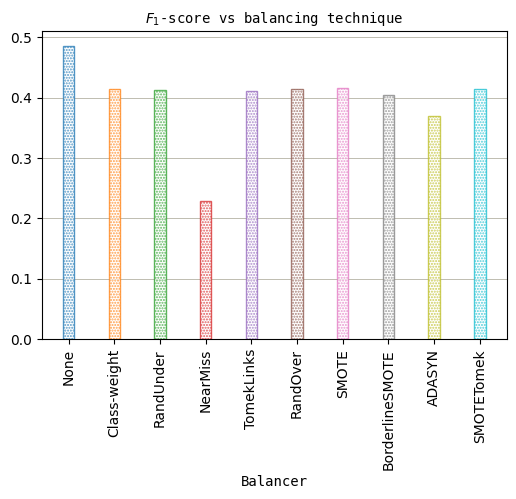

In [189]:
plot_bar(pd.DataFrame(balancers_to_eval), 'name', 'f1', 'Balancer', '$F_{1}$-score vs balancing technique', rot=90)

We can see that balancing does not help improve our model (Logistic Regression classifier in this case), rather it only can "switch" precision and recall. $F_{1}$-score is even better without balancing. So, it looks like balancing cannot help improve our classifier this time. Balancing forces the classifier to pay more attention to the minority class but cannot automatically improve the quality of the classifier. Recall the dummy classifier that does not predict the positive class at all. Can balancing make it a better one? Obviously, it can't.

Right now, our classifier can only do one job well: either have higher precision (fewer type I errors) with no balancing, or higher recall (fewer type II errors) with balancing, but not both. Let's plot precision and recall vs the probability thresholds to demonstrate it. As with evaluating balancers, we'll use `val` for evaluation.

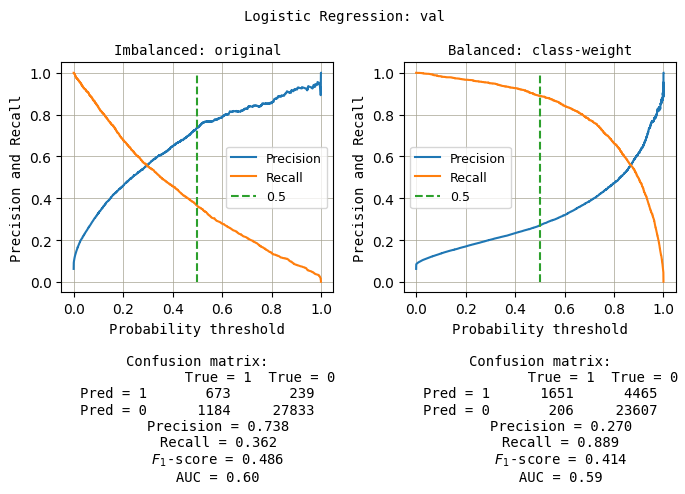

In [190]:
plt.figure(figsize=(7, 5))
for i in (1, 2):
    if i == 1:
        pipe = make_pipeline(column_transformer_lm, LogisticRegression())
        title = 'Imbalanced: original'
    else: # i == 2
        pipe = make_pipeline(column_transformer_lm, LogisticRegression(class_weight='balanced'))
        title = 'Balanced: class-weight'
    plt.subplot(1, 2, i)
    pipe.fit(X_train, y_train)
    precision, recall, thresholds = precision_recall_curve(y_val, pipe.predict_proba(X_val)[:, 1])
    pc_auc = auc(recall, precision)
    plt.plot(thresholds, precision[:-1], color='C0', label='Precision')
    plt.plot(thresholds, recall[:-1], color='C1', label='Recall')
    plt.vlines(0.5, 0.0, 1.0, ls='--', color='C2', label='0.5')
    plt.ylabel('Precision and Recall', size=10, fontfamily='monospace')
    y_pred_val = pipe.predict(X_val)
    cm = pd.DataFrame(
        confusion_matrix(y_val, y_pred_val, labels=[1, 0]),
        columns=['Pred = 1', 'Pred = 0'],
        index=['True = 1', 'True = 0']).T
    plt.xlabel(f'Probability threshold\n\nConfusion matrix:\n \
    {cm}\n \
    Precision = {precision_score(y_val, y_pred_val):.3f}\n \
    Recall = {recall_score(y_val, y_pred_val):.3f}\n \
    $F_{1}$-score = {f1_score(y_val, y_pred_val):.3f}\n \
    AUC = {pc_auc:.2f}', size=10, fontfamily='monospace')
    plt.title(f'{title}', size=10, fontfamily='monospace')
    plt.legend(fontsize=9)
    plt.grid(lw=0.5, color='xkcd:cement')
plt.suptitle('Logistic Regression: val', size=10, fontfamily='monospace')
plt.tight_layout();

These two plots confirm that, regardless of the threshold and balancing the target classes, the classifier is good at either precision or recall. And AUC (Area Under the Precision-Recall Curve) is almost the same. So, we should focus on building a better classifier. Since our target metric is precision and the imbalanced data offers better precision-recall trade-off (left plot), we will not use balancing techniques in our final pipeline.

* 3.2. (9%) Train different machine learning models, including the advanced boosting algorithms studied during the course. Carefully tune hyperparameters of the algorithms. You are supposed to compare at least 3 models

Consider 5 models, discussed in [2.2](#encoding). First let's see the models' performance with default hyperparameters (out of the box, non-optimized). As with assessing the balancers, we will use `val` here.

In [191]:
models_to_eval = [{'name': 'LR', 'model': LogisticRegression(random_state=seed, n_jobs=-1), 'transformer': column_transformer_lm},
                  {'name': 'RF', 'model': RandomForestClassifier(random_state=seed, n_jobs=-1), 'transformer': column_transformer_dt},
                  {'name': 'XGBoost', 'model': XGBClassifier(random_state=seed, n_jobs=-1), 'transformer': column_transformer_dt},
                  {'name': 'LightGBM', 'model': LGBMClassifier(random_state=seed, n_jobs=-1), 'transformer': column_transformer_dt},
                  {'name': 'CatBoost', 'model': CatBoostClassifier(random_state=seed), 'transformer': column_transformer_dt}
                  ]

In [192]:
for model_to_eval in tqdm(models_to_eval):
    pipe = make_pipeline(model_to_eval['transformer'], model_to_eval['model'])
    y_pred = pipe.fit(X_train, y_train).predict(X_val)
    model_to_eval['precision_val'] = precision_score(y_val, y_pred)

 60%|██████    | 3/5 [00:22<00:13,  6.91s/it]

[LightGBM] [Info] Number of positive: 12997, number of negative: 196502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 209499, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062038 -> initscore=-2.715954
[LightGBM] [Info] Start training from score -2.715954


 80%|████████  | 4/5 [00:24<00:05,  5.06s/it]

Learning rate set to 0.100944
0:	learn: 0.5188924	total: 155ms	remaining: 2m 34s
1:	learn: 0.3942485	total: 168ms	remaining: 1m 23s
2:	learn: 0.3134324	total: 182ms	remaining: 1m
3:	learn: 0.2602771	total: 196ms	remaining: 48.7s
4:	learn: 0.2243788	total: 209ms	remaining: 41.7s
5:	learn: 0.1967977	total: 224ms	remaining: 37.1s
6:	learn: 0.1793039	total: 238ms	remaining: 33.8s
7:	learn: 0.1658068	total: 252ms	remaining: 31.3s
8:	learn: 0.1570359	total: 266ms	remaining: 29.3s
9:	learn: 0.1516944	total: 279ms	remaining: 27.6s
10:	learn: 0.1469778	total: 292ms	remaining: 26.3s
11:	learn: 0.1434538	total: 307ms	remaining: 25.3s
12:	learn: 0.1401816	total: 320ms	remaining: 24.3s
13:	learn: 0.1374461	total: 334ms	remaining: 23.5s
14:	learn: 0.1347113	total: 348ms	remaining: 22.9s
15:	learn: 0.1330382	total: 362ms	remaining: 22.3s
16:	learn: 0.1314740	total: 375ms	remaining: 21.7s
17:	learn: 0.1300286	total: 389ms	remaining: 21.2s
18:	learn: 0.1287496	total: 403ms	remaining: 20.8s
19:	learn: 0

100%|██████████| 5/5 [00:39<00:00,  7.99s/it]


In [193]:
models_non_opt = pd.DataFrame(models_to_eval)[['name', 'precision_val']]
models_non_opt.sort_values(by='precision_val', ascending=False)

name  precision_val
4  CatBoost       0.743266
1        RF       0.738848
0        LR       0.737939
3  LightGBM       0.731810
2   XGBoost       0.700375

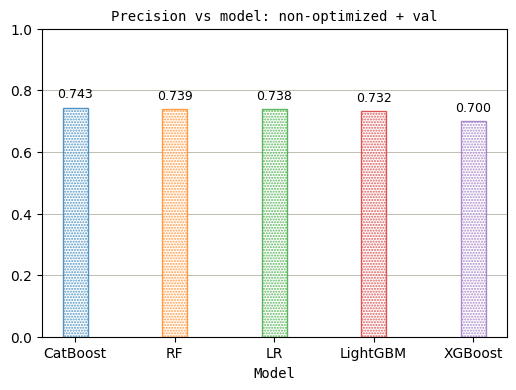

In [194]:
plot_bar(models_non_opt.sort_values(by='precision_val', ascending=False), 'name', 'precision_val', 'Model', 'Precision vs model: non-optimized + val', bar_label=True, ylim=[0.0, 1.0], rot=0)

Let's also take a look at the Precision-Recall curves for all models. AUC is shown in the parentheses. The ideal classifier would have AUC = 1.0, and a random classifier would have AUC = $P$(Class=1) $\approx$ 0.062 in our case.

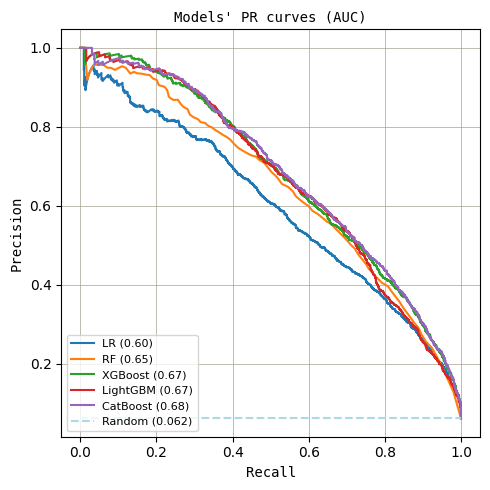

In [195]:
plot_pr_auc(models_to_eval, 'model', X_train, y_train, X_val, y_val)

We can see that the decision tree-based models perform better than the linear model, and boosting models are competing for leadership. By the way, this plot is a good confirmation that __we _can_ build a better classifier even with imbalanced data by using different machine learning algorithms__.

Now, it's time to fine-tune our models to find best classifiers within each model family. To do that, we'll use grid search over the following models' hyperparameters:
- Logistic Regression:
    - C (inverse of coefficient of regularization $\lambda$). If C = 1.0, then no regularization is applied to the model's weights;
    - penalty (type of regularization norm): no, $L_{1}$, $L_{2}$, both (not all values are compatible with every solver);
- Random Forest:
    - number of trees in the forest;
    - maximal depth of each tree. If maximal depth is not set, then nodes are split until all leaves are pure, which may cause high variance and thus overfitting;
- XGBoost, LightGBM, and CatBoost:
    - number of estimators (trees) in ensemble
    - maximal depth of each tree. If maximal depth is not set, then nodes are split until all leaves are pure. Usually the trees are shallow (not deep).

In [196]:
param_grid = [
    {
        'column_transformer': [column_transformer_lm],
        'clf': [LogisticRegression(random_state=seed, n_jobs=-1)],
        'clf__C': [0.1, 1.0, 10.0],
        'clf__penalty': [None, 'l2']
    },
    {
        'column_transformer': [column_transformer_dt],
        'clf': [RandomForestClassifier(random_state=seed, n_jobs=-1)],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [10, 20, 50]
    },
    {
        'column_transformer': [column_transformer_dt],
        'clf': [XGBClassifier(random_state=seed, n_jobs=-1)],
        'clf__n_estimators': [100, 300, 500],
        'clf__max_depth': [3, 5, 7, 9]
    },
    {
        'column_transformer': [column_transformer_dt],
        'clf': [LGBMClassifier(random_state=seed, n_jobs=-1)],
        'clf__n_estimators': [100, 300, 500],
        'clf__max_depth': [3, 5, 7, 9]
    },
    {
        'column_transformer': [column_transformer_dt],
        'clf': [CatBoostClassifier(random_state=seed)],
        'clf__n_estimators': [100, 300, 500],
        'clf__max_depth': [3, 5, 7, 9]
    }
]

Finally, we will try to find final best classifiers with our __chosen Stratified K-Fold cross-validation strategy__ on `train` using grid search. sklearn does stratification automatically for binary targets (our case).

In [197]:
pipe = Pipeline([('column_transformer', None), ('clf', None)])
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, refit=True, scoring='precision', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer', None),
                                       ('clf', None)]),
             n_jobs=-1,
             param_grid=[{'clf': [LogisticRegression(n_jobs=-1,
                                                     random_state=42)],
                          'clf__C': [0.1, 1.0, 10.0],
                          'clf__penalty': [None, 'l2'],
                          'column_transformer': [ColumnTransformer(n_jobs=-1,
                                                                   transformers=[('num_cols',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='me...
                                                                                                  ('catboostencoder',
                                                                                                   CatBoostEncoder(random_state=42))]),
                                                                                  ['sex',
                                                                                   'tax '
                                                                                   'filer '
                                                                                   'stat',
                                                                                   'class '
                                                                                   'of '
                                                                                   'worker',
                                                                                   'marital '
                                                                                   'stat',
                                                                                   'family '
                                                                                   'members '
                                                                                   'under '
                                                                                   '18',
                                                                                   'detailed '
                                                                                   'industry '
                                                                                   'recode',
                                                                                   'detailed '
                                                                                   'occupation '
                                                                                   'recode',
                                                                                   'education',
                                                                                   'full '
                                                                                   'or '
                                                                                   'part '
                                                                                   'time '
                                                                                   'employment '
                                                                                   'stat',
                                                                                   'detailed '
                                                                                   'household '
                                                                                   'and '
                                                                                   'family '
                                                                                   'stat',
                                              

In [198]:
# Overall best classifier
grid_search.best_estimator_

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'capital gains',
                                                   'capital losses',
                                                   'dividends from stocks',
                                                   'num persons worked for '
                                                   'employer',
                                                   'weeks worked in year']),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unkn...
                                                                   CatBoostEncoder(random_state=42))]),
                                                  ['sex', 'tax filer stat',
                                                   'class of worker',
                                                   'marital stat',
                                                   'family members under 18',
                                                   'detailed industry recode',
                                                   'detailed occupation recode',
                                                   'education',
                                                   'full or part time '
                                                   'employment stat',
                                                   'detailed household and '
                                                   'family stat',
                                                   'veterans benefits',
                                                   'group'])])),
                ('clf',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

In [199]:
models_opt = pd.DataFrame(grid_search.cv_results_)

In [200]:
models_opt['name'] = models_opt['param_clf'].apply(lambda x: x.__str__()).str.split('(', expand=True)[0]
models_opt.loc[lambda x: x['name'].str.contains('CatBoostClassifier'), 'name'] = 'CatBoostClassifier'
models_opt['name'] = models_opt['name'].str.replace('LogisticRegression', 'LR') \
                            .str.replace('RandomForestClassifier', 'RF') \
                            .str.replace('XGBClassifier', 'XGBoost') \
                            .str.replace('LGBMClassifier', 'LightGBM') \
                            .str.replace('CatBoostClassifier', 'CatBoost')

In [201]:
# Best models in their families optimized for precision
best_models = models_opt.iloc[models_opt.groupby('name')['mean_test_score'].idxmax()]
best_models[['name', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

name  mean_test_score
7         RF         0.772601
39  CatBoost         0.746718
27  LightGBM         0.746651
15   XGBoost         0.738982
1         LR         0.709281

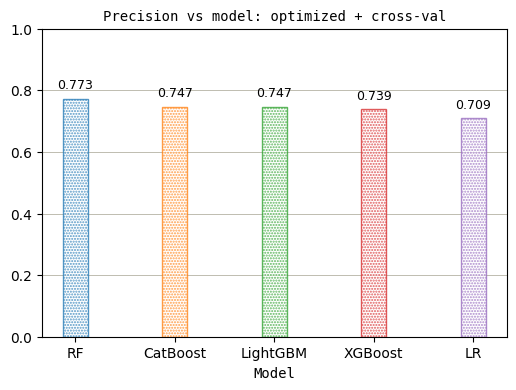

In [202]:
plot_bar(best_models.sort_values(by='mean_test_score', ascending=False), 'name', 'mean_test_score', 'Model', 'Precision vs model: optimized + cross-val', bar_label=True, ylim=[0.0, 1.0], rot=0)

In [203]:
# List parameters for each best model
best_models.filter(regex='param_clf__').merge(best_models['name'], on=best_models.index)

key_0 param_clf__C param_clf__penalty param_clf__max_depth  \
0     39          NaN                NaN                    3   
1      1          0.1                 l2                  NaN   
2     27          NaN                NaN                    3   
3      7          NaN                NaN                   10   
4     15          NaN                NaN                    3   

  param_clf__n_estimators      name  
0                     100  CatBoost  
1                     NaN        LR  
2                     100  LightGBM  
3                     200        RF  
4                     100   XGBoost

In [204]:
# Manually build objects for tuned models
# Note: grid search does not return fitted models, only the found hyperparameters,
# so we need to create the required models and fit them before making predictions
# Todo: automatically build tuned models with parameters extracted from grid search results
models_to_eval[0]['model_tuned'] = LogisticRegression(C=0.1, penalty='l2', random_state=seed, n_jobs=-1)
models_to_eval[1]['model_tuned'] = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=seed, n_jobs=-1)
models_to_eval[2]['model_tuned'] = XGBClassifier(n_estimators=100, max_depth=3, random_state=seed, n_jobs=-1)
models_to_eval[3]['model_tuned'] = LGBMClassifier(n_estimators=100, max_depth=3, random_state=seed, n_jobs=-1)
models_to_eval[4]['model_tuned'] = CatBoostClassifier(n_estimators=100, max_depth=3, random_state=seed)

Now, let's take a look at the Precision-Recall curves for all best models in their families.

[LightGBM] [Info] Number of positive: 12997, number of negative: 196502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 209499, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062038 -> initscore=-2.715954
[LightGBM] [Info] Start training from score -2.715954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Learning rate set to 0.5
0:	learn: 0.3824276	total: 7.88ms	remaining: 780ms
1:	learn: 0.2659897	total: 14.4ms	remaining: 704ms
2:	learn: 0.2070173	total: 20.4ms	remaining: 661ms
3:	learn: 0.1755650	total: 27ms	remai

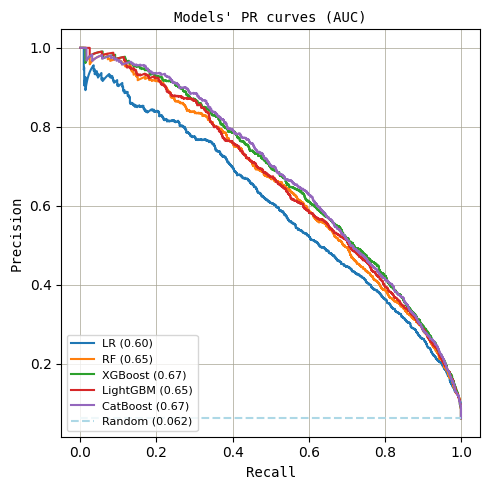

In [205]:
plot_pr_auc(models_to_eval, 'model_tuned', X_train, y_train, X_val, y_val, refit=True)

After hyperparameters optimization, __the best model, in terms of Precision, is `Random Forest`__ with 200 trees of depth 10. __The mean Precision = 0.773__ for 5-fold cross-validation on the train data, which is an increase from 0.739 without hyperparameters optimization. At the same time, if we look at both precision and recall, boosting models can offer better trade-off and have higher AUC than the Random Forest model, both before and after optimization.

Let's also take a look at the grid search space for Random Forest classifiers family.

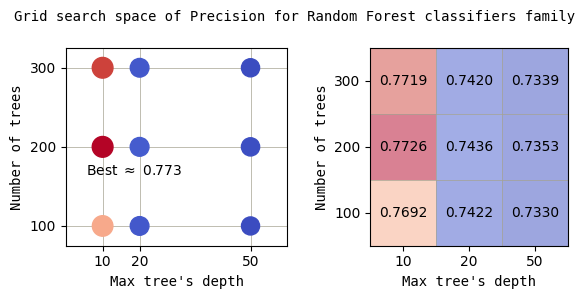

In [206]:
grid_space = models_opt[models_opt['name'] == 'RF']
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.scatter(grid_space['param_clf__max_depth'], grid_space['param_clf__n_estimators'], s=np.exp(7 * grid_space['mean_test_score']), c=np.exp(100 * grid_space['mean_test_score']), cmap='coolwarm')
plt.text(grid_space[grid_space['rank_test_score'] == 1]['param_clf__max_depth'].values[0] - 4.5, grid_space[grid_space['rank_test_score'] == 1]['param_clf__n_estimators'].values[0] - 35, f"Best $\\approx$ {grid_space[grid_space['rank_test_score'] == 1]['mean_test_score'].values[0]:.3f}")
plt.xticks([10, 20, 50], [10, 20, 50])
plt.yticks([100, 200, 300])
plt.xlim([0, 60])
plt.ylim([75, 325])
plt.xlabel("Max tree's depth", size=10, family='monospace')
plt.ylabel('Number of trees', size=10, family='monospace')
plt.gca().set_axisbelow(True)
plt.grid(lw=0.5, color='xkcd:cement')
plt.subplot(1, 2, 2)
plt.imshow(np.exp(100 * grid_space['mean_test_score']).values.reshape(3, 3).T[::-1], cmap='coolwarm', alpha=0.5)
for (j, i), label in np.ndenumerate(grid_space['mean_test_score'].values.reshape(3, 3).T[::-1]):
    plt.text(i, j, f'{label:.4f}', ha='center', va='center')
plt.xticks(range(3), [10, 20, 50])
plt.yticks(range(3), [300, 200, 100])
plt.xlabel("Max tree's depth", size=10, family='monospace')
plt.ylabel('Number of trees', size=10, family='monospace')
plt.xticks(np.arange(3) + 0.5, minor=True) # Turn on minor ticks only for plotting the grid
plt.yticks(np.arange(3) + 0.5, minor=True)
plt.grid(which='minor', lw=0.5, color='xkcd:cement')
plt.tick_params(which='minor', bottom=False, left=False); # Turn off minor ticks after plotting the grid
plt.suptitle('Grid search space of Precision for Random Forest classifiers family', size=10, family='monospace')
plt.tight_layout();

We can see that grid search chose not deep trees for the best model. This makes sense, since the deeper the tree, the more overfitted the model is, which leads to lower metrics during cross-validation, which is a good indication of the model's performance on the test data.

* 3.3. (8%) Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble

Now, let's build an ensemble of our 5 best models (after optimization) to check, if we can enhance our classifier. For that we'll use the blending technique — predictions of single models are added together to output the final predictions. Each model's predictions vector is taken with some weight, thus the name "blending". The idea it to find such weights vector that the blended predictions are optimal w.r.t. to our target metric: $w_{opt} = \underset{w}{\argmax}(\text{Precision}|_{\hat y(w)})$.

First, let's compute predictions from all 5 best models. The models were trained above in the "plot_pr_auc" function. We'll use `val` for validation.

In [207]:
best_models_preds = pd.DataFrame(columns=[model_to_eval['name'] for model_to_eval in models_to_eval])
for model_to_eval in tqdm(models_to_eval):
    pipe = make_pipeline(model_to_eval['transformer'], model_to_eval['model_tuned'])
    best_models_preds[model_to_eval['name']] = pipe.predict(X_val)

100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


In [208]:
best_models_preds

LR  RF  XGBoost  LightGBM  CatBoost
0       0   0        0         0         0
1       0   0        0         0         0
2       0   0        0         0         0
3       0   0        0         0         0
4       0   0        0         0         0
...    ..  ..      ...       ...       ...
29924   0   0        0         0         0
29925   0   0        0         0         0
29926   0   0        0         0         0
29927   0   0        1         0         1
29928   0   0        0         0         0

[29929 rows x 5 columns]

We will search over some weights space.

In [209]:
weights_space = np.linspace(0.0, 1.0, 11)
weights_space = np.array(list(product(weights_space, repeat=5))) # construct all possible weights combinations with repetitions
weights_space = weights_space[weights_space.sum(axis=1) == 1.0] # keep only those that add up to 1.0
weights_space

array([[0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0.1, 0.9],
       [0. , 0. , 0. , 0.2, 0.8],
       ...,
       [0.9, 0. , 0.1, 0. , 0. ],
       [0.9, 0.1, 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. ]])

In [210]:
# This many model blends (weights blends) to check
weights_space.shape

(877, 5)

Next, let's find the optimal weights by optimizing for our target metric precision.

In [211]:
precision_by_weights = pd.DataFrame(columns=['weights', 'precision'])
for weights in tqdm(weights_space):
    # Ensemble predictions is simply the dot products of predictions from single models and corresponding model weights
    precision = precision_score(y_val, (best_models_preds @ weights.T).astype(int))
    precision_by_weights.loc[len(precision_by_weights)] = [weights, precision]

100%|██████████| 877/877 [00:07<00:00, 122.94it/s]


In [212]:
precision_by_weights

weights  precision
0                            [0.0, 0.0, 0.0, 0.0, 1.0]   0.745184
1                            [0.0, 0.0, 0.0, 0.1, 0.9]   0.765594
2                            [0.0, 0.0, 0.0, 0.2, 0.8]   0.765594
3    [0.0, 0.0, 0.0, 0.30000000000000004, 0.7000000...   0.765594
4             [0.0, 0.0, 0.0, 0.4, 0.6000000000000001]   0.765594
..                                                 ...        ...
872                          [0.9, 0.0, 0.0, 0.0, 0.1]   0.805412
873                          [0.9, 0.0, 0.0, 0.1, 0.0]   0.798177
874                          [0.9, 0.0, 0.1, 0.0, 0.0]   0.804688
875                          [0.9, 0.1, 0.0, 0.0, 0.0]   0.823944
876                          [1.0, 0.0, 0.0, 0.0, 0.0]   0.737939

[877 rows x 2 columns]

In [213]:
# Optimal weights to maximize precision
weights_opt = precision_by_weights.iloc[precision_by_weights['precision'].idxmax()]['weights']
weights_opt

array([0.1, 0.1, 0.1, 0.1, 0.6])

In [214]:
# Model contributions to the ensemble
pd.DataFrame(precision_by_weights.iloc[precision_by_weights['precision'].idxmax()]['weights'], index=best_models_preds.columns, columns=['weights']).T

LR   RF  XGBoost  LightGBM  CatBoost
weights  0.1  0.1      0.1       0.1       0.6

CatBoost is the major vote in the ensemble. Contributions by single models:
- Logistic Regression: 10%;
- Random Forest: 10%;
- XGBoost: 10%;
- LightGBM: 10%;
- CatBoost: 60%.

Finally, we can use the sklearn's `VotingClassifier` to build a classifier that can blend individual predictions with weights and has standard methods like fit, predict, and predict_proba — exactly what we want. Parameter "voting" can be set to "hard" for simple majority rule voting or "soft" to apply argmax of the sums of the predicted probabilities, when generating predicted class labels. We'll use "soft" voting.

In [215]:
# Build voting classifier from all 5 tuned models, using the found optimal weights
model_ensemble = VotingClassifier(estimators=[(model_to_eval['name'], make_pipeline(model_to_eval['transformer'], model_to_eval['model_tuned'])) for model_to_eval in models_to_eval], voting='soft', weights=weights_opt)
model_ensemble

VotingClassifier(estimators=[('LR',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(n_jobs=-1,
                                                                 transformers=[('num_cols',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('standardscaler',
                                                                                                 StandardScaler())]),
                                                                                ['age',
                                                                                 'capital '
                                                                                 'gains',
                                                                                 'capital '
                                                                                 'losses',
                                                                                 'dividends '
                                                                                 'from '
                                                                                 'stocks',
                                                                                 'num '
                                                                                 'persons '
                                                                                 'worked '
                                                                                 'for '
                                                                                 'employer',
                                                                                 'weeks '
                                                                                 'worke...
                                                                                 'family '
                                                                                 'members '
                                                                                 'under '
                                                                                 '18',
                                                                                 'detailed '
                                                                                 'industry '
                                                                                 'recode',
                                                                                 'detailed '
                                                                                 'occupation '
                                                                                 'recode',
                                                                                 'education',
                                                                                 'full '
                                                                                 'or '
                                                                                 'part '
                                                                                 'time '
                                                                                 'employment '
                                                                                 'stat',
                                                                                 'detailed '
                                                                                 'household '
                                                                                 'and '
                                                                  

In [216]:
# Check
model_ensemble.weights

array([0.1, 0.1, 0.1, 0.1, 0.6])

In [217]:
# Add the ensemble to our models
models_to_eval.append({'name': 'Ensemble', 'model': None, 'transformer': None, 'model_tuned': model_ensemble})

Now, let't take a look at the Precision-Recall curves for our best single model (Random Forest) and Ensemble, which now has CatBoost as the major voter, based on the optimal weights.

[LightGBM] [Info] Number of positive: 12997, number of negative: 196502
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 209499, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062038 -> initscore=-2.715954
[LightGBM] [Info] Start training from score -2.715954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Learning rate set to 0.5
0:	learn: 0.3824276	total: 9.24ms	remaining: 914ms
1:	learn: 0.2659897	total: 16.2ms	remaining: 793ms
2:	learn: 0.2070173	total: 22.6ms	remaining: 730ms
3:	learn: 0.1755650	total: 28.5ms	remaining: 684ms
4:	learn: 0.1569027	total: 35.3ms	remaining: 671ms

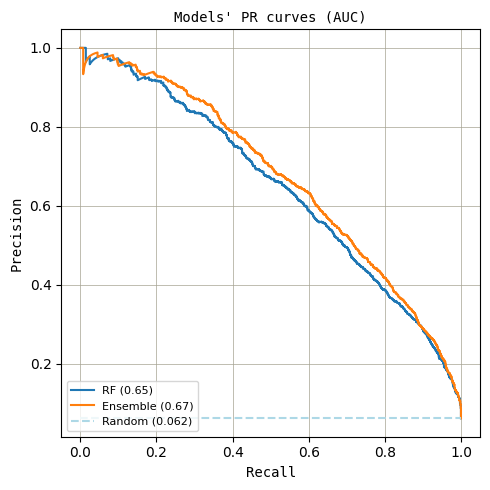

In [218]:
plot_pr_auc([models_to_eval[1], models_to_eval[5]], 'model_tuned', X_train, y_train, X_val, y_val, refit=True)

We can see, that our ensemble can offer a better precision-recall trade-off and higher AUC as compared to the single best model.

### <a id="summary"></a>[25%] 4. Summary

* 4.1. (8%) Estimate the quality of the models and their ensemble on the test set. Describe the results. Which model is the best?

Now, we can finally estimate the quality of our models on `test`.

In [219]:
for model_to_eval in tqdm(models_to_eval):
    pipe = make_pipeline(model_to_eval['transformer'], model_to_eval['model_tuned'])
    model_to_eval['precision_test'] = precision_score(y_test, pipe.predict(X_test))

100%|██████████| 6/6 [00:03<00:00,  1.53it/s]


In [220]:
models_opt_test = pd.DataFrame(models_to_eval)[['name', 'precision_test']]
models_opt_test.sort_values(by='precision_test', ascending=False)

name  precision_test
1        RF        0.781726
5  Ensemble        0.778309
4  CatBoost        0.766682
3  LightGBM        0.765989
2   XGBoost        0.763914
0        LR        0.731559

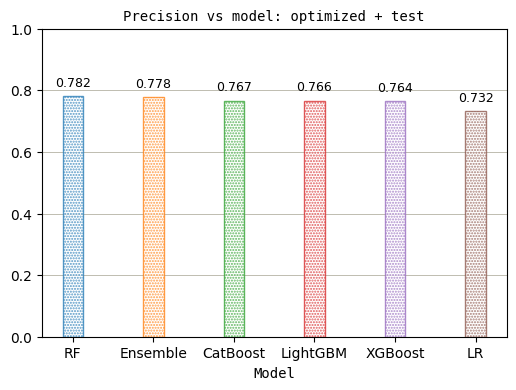

In [221]:
plot_bar(models_opt_test.sort_values(by='precision_test', ascending=False), 'name', 'precision_test', 'Model', 'Precision vs model: optimized + test', bar_label=True, ylim=[0.0, 1.0], rot=0)

Now, let's once again take a look at the Precision-Recall curves for all best models in their families and their ensemble, but for `test` this time.

In [222]:
plot_pr_auc(models_to_eval, 'model_tuned', X_train, y_train, X_test, y_test)

We can see that our __single models and their ensemble perform as good on the test data__ as on the validation data and train data during cross-validation. The Random Forest single model's Precision = 0.782, while ensemble's = 0.778. As for precision-recall trade-off, the ensemble is competing with boosting models — AUC = 0.67, leaving Random Forest behind — AUC = 0.65. Now, since the ensemble has higher AUC by 0.67 - 0.65 = 0.02 than the best single model (Random Forest), but at the same time, the difference in their precisions is 0.782 - 0.778 = 0.004, we can conclude, that ___the ensemble_ is the best model__.

* 4.2. (8%) Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)

4.2.1. Best single model (Random Forest)

We'll start with a basic model interpretation, which for decision tree-based models is [feature importances](#feat-importance). It is evaluated as the normalized total reduction of the criterion brought by that feature: gini, entropy, etc. By default for Random Forest, gini criterion is used as the criterion to measure the quality of a split (we didn't change this hyperparameter during training). The higher the reduction, i.e. the more impurity the feature eliminates, the more important the feature is believed to be.

> Quick warning: Impurity-based feature importances can be misleading for high cardinality features (many unique values).

In [223]:
feature_importances_best_single = pd.DataFrame(
                                                grid_search.best_estimator_[1].feature_importances_, 
                                                index=grid_search.best_estimator_.feature_names_in_, 
                                                columns=['importance']
                                                ) \
                                                .reset_index() \
                                                .rename(columns={'index': 'feature'}) \
                                                .sort_values(by='importance', ascending=False)
# Importances are normalized to 1.0
feature_importances_best_single

feature  importance
12          detailed occupation recode    0.200977
13                           education    0.144433
17                               group    0.104409
1                        capital gains    0.103904
3                dividends from stocks    0.095420
6                                  sex    0.061238
5                 weeks worked in year    0.050520
0                                  age    0.044223
11            detailed industry recode    0.039873
15  detailed household and family stat    0.029643
2                       capital losses    0.028803
4      num persons worked for employer    0.020917
8                      class of worker    0.020515
7                       tax filer stat    0.017297
9                         marital stat    0.017293
14   full or part time employment stat    0.007937
16                   veterans benefits    0.006673
10             family members under 18    0.005924

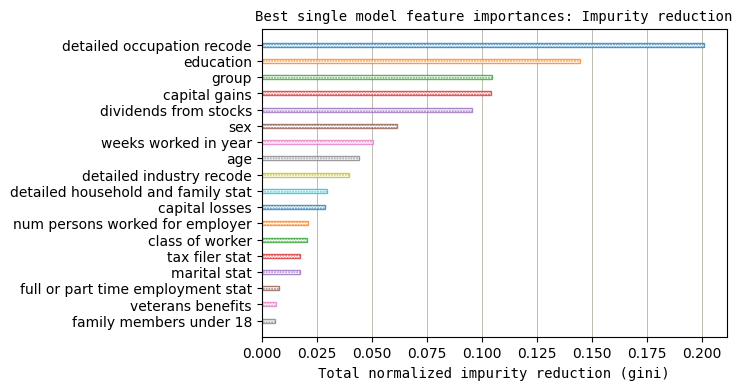

In [224]:
plot_bar(feature_importances_best_single, 'feature', 'importance', 'Total normalized impurity reduction (gini)', 'Best single model feature importances: Impurity reduction', 'horizontal')

Our findings:
- Top-3 _most_ important features are `detailed occupation recode`, `education`, and `group` (new feature after clustering);
- Top-3 _least_ important features are `full or part time employment stat`, `veterans benefits`, and `family members under 18`. 

We can also look at the top nodes of some individual decision tree in our best single model (Random Forest). Though, when building a tree (splitting nodes), features are taken randomly from the subset of "max_features" features (we did not change this hyperparameter), it looks like the most important features often appear at the top of the tree.

In [225]:
idx = np.random.choice(len(grid_search.best_estimator_[1].estimators_))
print(tree.export_text(grid_search.best_estimator_[1].estimators_[idx], feature_names=grid_search.best_estimator_.feature_names_in_, max_depth=1))

|--- group <= 0.06
|   |--- detailed occupation recode <= 0.15
|   |   |--- truncated branch of depth 9
|   |--- detailed occupation recode >  0.15
|   |   |--- truncated branch of depth 9
|--- group >  0.06
|   |--- capital gains <= 10041.00
|   |   |--- truncated branch of depth 9
|   |--- capital gains >  10041.00
|   |   |--- truncated branch of depth 9



Let's look at the top values of the top-3 most important features after encoding. Recall, that for categorical features we used CatBoost encoding (column transformer), which is a target-based encoding, so we can expect to see our features transformed into the target's probability space.

> Quick note: these values are _not_ model predictions, but we still would like to look at them to see, if our model can (or cannot) explain these dependencies between the target and features. 

In [226]:
# Fit-transform feature matrix for train data and convert it into Pandas dataframe
col_names_trans = [f'{_}_transformed' for _ in grid_search.best_estimator_.feature_names_in_]
X_train_trans = make_pipeline(column_transformer_dt, FunctionTransformer(lambda x: pd.DataFrame(x, columns=col_names_trans))).fit_transform(X_train, y_train)
X_train_trans.iloc[sorted(np.random.choice(X_train_trans.shape[0], 5, replace=False))]

age_transformed  capital gains_transformed  \
51728              13.0                        0.0   
53400              23.0                        0.0   
133490             33.0                        0.0   
154718             36.0                        0.0   
166552             57.0                        0.0   

        capital losses_transformed  dividends from stocks_transformed  \
51728                          0.0                                0.0   
53400                          0.0                                0.0   
133490                         0.0                                0.0   
154718                         0.0                             6000.0   
166552                      1902.0                                1.0   

        num persons worked for employer_transformed  \
51728                                           0.0   
53400                                           6.0   
133490                                          1.0   
154718                                          3.0   
166552                                          6.0   

        weeks worked in year_transformed  sex_transformed  \
51728                                0.0         0.025471   
53400                               52.0         0.025330   
133490                              52.0         0.025617   
154718                              51.0         0.025811   
166552                              52.0         0.101446   

        tax filer stat_transformed  class of worker_transformed  \
51728                     0.000671                     0.008439   
53400                     0.059065                     0.008361   
133490                    0.132443                     0.101797   
154718                    0.132282                     0.101730   
166552                    0.132512                     0.119928   

        marital stat_transformed  family members under 18_transformed  \
51728                   0.012659                             0.000006   
53400                   0.012698                             0.084761   
133490                  0.114573                             0.085492   
154718                  0.114443                             0.085607   
166552                  0.114600                             0.085612   

        detailed industry recode_transformed  \
51728                               0.008436   
53400                               0.008358   
133490                              0.127585   
154718                              0.036454   
166552                              0.109198   

        detailed occupation recode_transformed  education_transformed  \
51728                                 0.008436               0.000005   
53400                                 0.008358               0.038740   
133490                                0.315773               0.074436   
154718                                0.006924               0.201646   
166552                                0.268709               0.504416   

        full or part time employment stat_transformed  \
51728                                        0.046490   
53400                                        0.046342   
133490                                       0.047021   
154718                                       0.034087   
166552                                       0.132498   

        detailed household and family stat_transformed  \
51728                                         0.000005   
53400                                         0.005933   
133490                                        0.055686   
154718                                        0.147179   
166552                                        0.147658   

        veterans benefits_transformed  group_transformed  
51728                        0.000005           0.050929  
53400                        0.079779           0.050619  
133490                       0.080486           0.050853  
154718                       0.080599           

In [227]:
# 1. Detailed occupation recode
feature_name = 'detailed occupation recode'
# Source: https://microdata.epi.org/variables/indocc/docc03/
# The data is for 2003, hopefully the codes were the same in 1994
det_occ_rec_meaning = pd.DataFrame([{
                                    1: 'Management', 
                                    2: 'Business and financial operations', 
                                    3: 'Computer and mathematical science', 
                                    4: 'Architecture and engineering',
                                    5: 'Life, physical, and social science',
                                    6: 'Community and social service',
                                    7: 'Legal',
                                    8: 'Education, training, and library',
                                    9: 'Arts, design, entertainment, sports, and media',
                                    10: 'Healthcare practitioner and technical',
                                    11: 'Healthcare support',
                                    17: 'Office and administrative support occupations'
                                    }], index=['occupation meaning']).T
# Combine transformed features with original values
feature_df = pd.concat([X_train.reset_index(drop=True), X_train_trans], axis=1).groupby(feature_name)
# Top-5
pd.DataFrame(feature_df[feature_name+'_transformed'].mean().sort_values(ascending=False)).merge(det_occ_rec_meaning, left_on=feature_name, right_on=det_occ_rec_meaning.index).head(5)

detailed occupation recode  detailed occupation recode_transformed  \
0                           7                                0.673853   
1                          11                                0.641268   
2                           4                                0.496188   
3                           5                                0.390999   
4                           6                                0.325335   

                   occupation meaning  
0                               Legal  
1                  Healthcare support  
2        Architecture and engineering  
3  Life, physical, and social science  
4        Community and social service

Legal, healthcare, architecture and engineering occupations are the leaders.

In [228]:
# 2. Education
feature_name = 'education'
# Combine transformed features with original values
feature_df = pd.concat([X_train.reset_index(drop=True), X_train_trans], axis=1).groupby(feature_name)
# Top-5
feature_df[feature_name+'_transformed'].mean().sort_values(ascending=False).head(5)

education
Prof school degree (MD DDS DVM LLB JD)    0.530482
Doctorate degree(PhD EdD)                 0.478429
Masters degree(MA MS MEng MEd MSW MBA)    0.311126
Bachelors degree(BA AB BS)                0.197775
Associates degree-academic program        0.097774
Name: education_transformed, dtype: float64

Professional school, doctorate and masters degree levels of education are the leaders.

Next, we'll look at [Partial Dependence (PD)](#feat-importance) of the target from individual features. The idea is to predict the target for a number of values of a feature (within its domain), i.e. to compute the target prediction as a function of some feature, keeping other (complementary) features intact. If the target prediction function responds to different values of a feature, then this feature is considered as important, otherwise not. These predictions are Individual Conditional Expectations (ICE) for each feature of interest. PD for a feature is simply the average of its ICEs. The main advantage of this model interpretation method is that we do not make any assumptions about linear / non-linear dependencies of the target from the features — we simply assess these dependences from real model predictions. A Partial Dependence Plot (PDP) is then created for each feature. It can be line, scatter, bar plot, etc.

> Quick warnings:
> - PD method has an assumption of feature independence between each other, which we checked while doing feature engineering;
> - Not all combinations of values of features, make sense for all observations. For example, school students (age) most likely cannot be employed. This is important for non-independent features, for which such surrogate observations are rather impossible, but again we tried to include only mutually independent features in our model.

To speed up, let's use `val` for predictions. We can expect similar results on `test`, since our model has similar performances on `train` cross-val, `val`, and `test`.

In [229]:
# Numerical features
ice_perc = 68 # %
feat_perc = 100 # %
ncols = 3
nrows = int(np.ceil(len(num_cols) / ncols))
plt.figure(figsize=(ncols * 3, nrows * 3))
for i, feature_name in enumerate(num_cols, start=1):
    plt.subplot(nrows, ncols, i)
    pdp_df = predict_partial(X_val, feature_name, grid_search.best_estimator_, kind='num', grid_size=10, ice_perc=ice_perc, feat_perc=feat_perc)
    # Show PDP
    plt.plot(pdp_df['Value'], pdp_df['Pred_mean'], color='C0')
    # Show ICE as shaded area, as per `ice_perc`
    plt.plot(pdp_df['Value'], pdp_df['ICE_hi'], color='C1', lw=0.5, alpha=0.5)
    plt.plot(pdp_df['Value'], pdp_df['ICE_lo'], color='C1', lw=0.5, alpha=0.5)
    plt.fill_between(pdp_df['Value'], pdp_df['ICE_hi'], pdp_df['ICE_lo'], color='lightgrey', alpha=0.25)
    plt.xlabel(f'{feature_name}\n({feat_perc}%)', size=9, family='monospace')
    plt.ylabel('$P$(Class=1)', size=9, family='monospace')
    plt.suptitle(f'PDP for numerical features (shaded area for {ice_perc}% ICE boundaries)', size=10, family='monospace')
    plt.grid(lw=0.5, color='xkcd:cement')
plt.tight_layout();

Our findings:
- The target responds to all numerical features;
- Recall the age profile during feature engineering: middle-aged participants earn more than younger and older ones. Here we no longer observe this dependence. This is because our model has not only age, but another 17 features, and age still influences the target, but not solely.

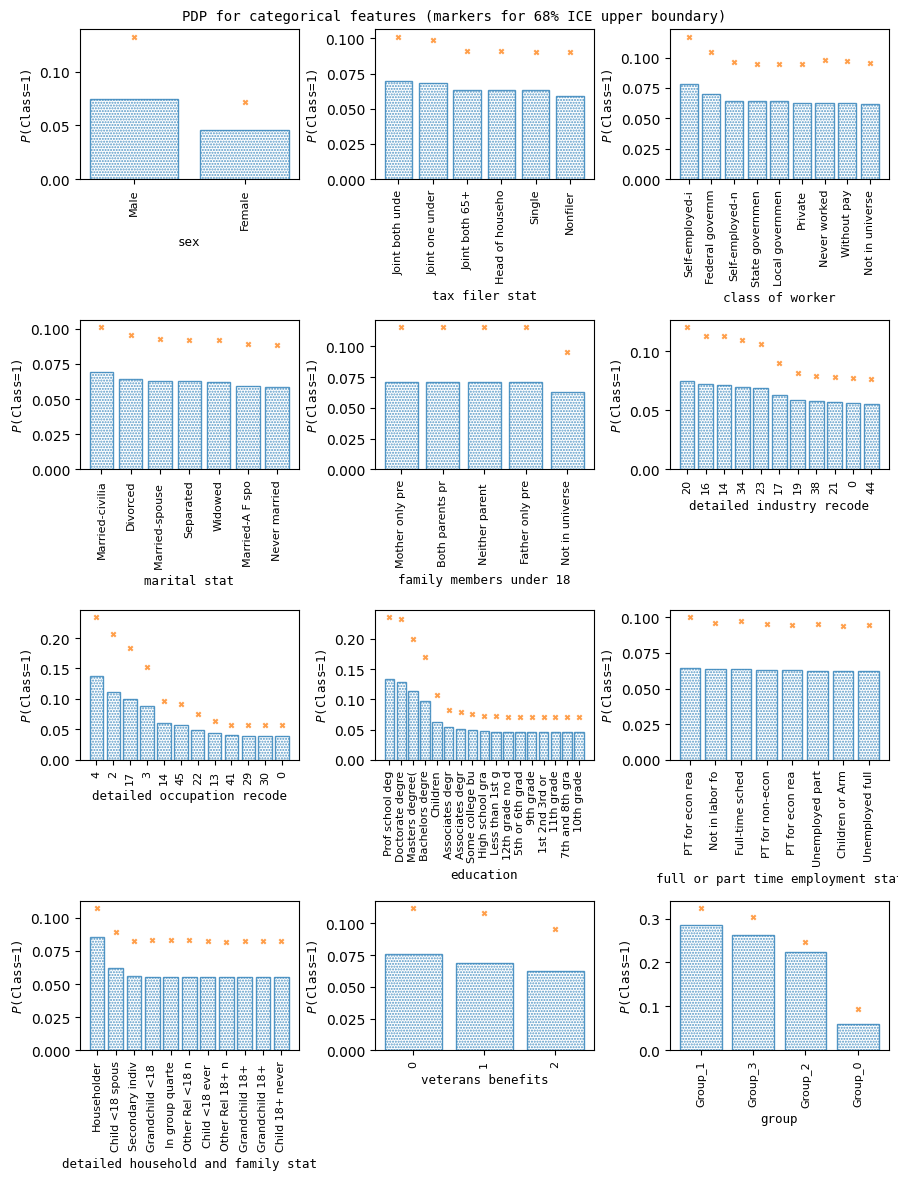

In [230]:
# Categorical features
ice_perc = 68 # %
ncols = 3
nrows = int(np.ceil(len(cat_cols) / ncols))
plt.figure(figsize=(ncols * 3, nrows * 3))
for i, feature_name in enumerate(cat_cols, start=1):
    plt.subplot(nrows, ncols, i)
    pdp_df = predict_partial(X_val, feature_name, grid_search.best_estimator_, kind='cat', grid_size=10, ice_perc=ice_perc).sort_values(by='Pred_mean', ascending=False)
    # Show PDP
    plt.bar(pdp_df['Value'].astype(str), pdp_df['Pred_mean'], color='white', edgecolor='C0', alpha=0.75, hatch='.'*6, error_kw={'lw': 0.5, 'ecolor': 'black', 'capsize': 1})
    # Show ISE upper boundary, as per `ice_perc`
    plt.scatter(pdp_df['Value'].astype(str), pdp_df['ICE_hi'], marker='x', s=10, color='C1', alpha=0.75)
    plt.xlabel(feature_name, size=9, family='monospace')
    plt.ylabel('$P$(Class=1)', size=9, family='monospace')
    plt.xticks(range(len(pdp_df['Value'])), [f'{str(_)[:15]}' for _ in pdp_df['Value']], size=8, rotation=90) # Limit xticks 
    plt.suptitle(f'PDP for categorical features (markers for {ice_perc}% ICE upper boundary)', size=10, family='monospace')
plt.tight_layout();

Once again, we can confirm that the target strongly responds to `detailed occupation recode` and `education` — our most important features. At the same time, target does not seem to respond much to `full or part time employment stat` and `family members under 18` which are the least important features.

Finally, let's explain our model with [Shapley Additive Explanations (SHAP)](#feat-importance) method. The idea is to compute the so-called Shapley values. For a number of feature values (within its domain), the estimated Shapley value is the contribution of a feature value to the difference between the actual prediction of the model and its mean prediction. The main advantage of this model interpretation method is that we do not make any assumptions about linear / non-linear dependencies of the target from the features — we simply assess these dependences from real model predictions.

In [253]:
# We will use the TreeExplainer object, since our best single model (Random Forest) is an ensemble of decision trees.
shap_explainer_best_single = TreeExplainer(model=grid_search.best_estimator_[1], random_state=seed)
# Computing Shapley values can be expensive, so we'll take a small random portion of `X_val`.
# We don't have to use `X_train`, since SHAP does not retrain the model and can do estimations on any data.
idx = np.random.choice(X_val.shape[0], int(0.1 * X_val.shape[0]), replace=False)
shap_values_best_single = shap_explainer_best_single.shap_values(X=column_transformer_dt.fit_transform(X_val.iloc[idx], y_val.iloc[idx]))

In [254]:
shap_values_best_single_avg = pd.DataFrame(
                                            np.abs(shap_values_best_single[1]).mean(axis=0), 
                                            index=grid_search.best_estimator_.feature_names_in_, 
                                            columns=['mean_abs_shap_value']
                                            ) \
                                            .reset_index() \
                                            .rename(columns={'index': 'feature'}) \
                                            .sort_values(by='mean_abs_shap_value', ascending=False)
shap_values_best_single_avg

feature  mean_abs_shap_value
17                               group             0.047751
12          detailed occupation recode             0.027104
13                           education             0.025488
5                 weeks worked in year             0.018471
3                dividends from stocks             0.016322
6                                  sex             0.013521
0                                  age             0.011819
1                        capital gains             0.010796
15  detailed household and family stat             0.009817
11            detailed industry recode             0.008308
4      num persons worked for employer             0.006285
16                   veterans benefits             0.004446
7                       tax filer stat             0.004266
9                         marital stat             0.003835
10             family members under 18             0.002982
2                       capital losses             0.002928
8                      class of worker             0.002713
14   full or part time employment stat             0.001073

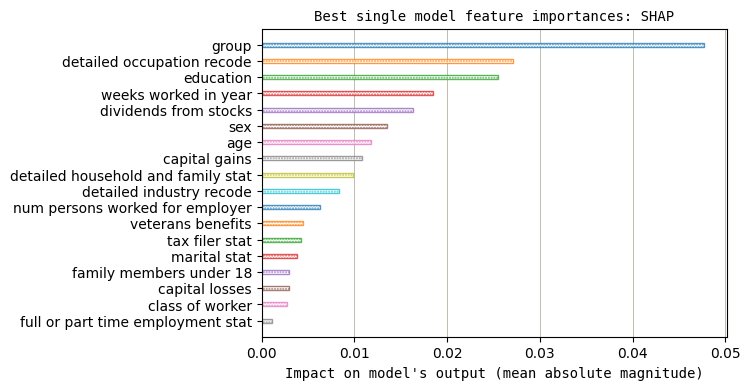

In [255]:
plot_bar(shap_values_best_single_avg, 'feature', 'mean_abs_shap_value', "Impact on model's output (mean absolute magnitude)", 'Best single model feature importances: SHAP', 'horizontal')

Our findings:
- `group`, `detailed occupation recode` and `education` are again the most important features;
- `full or part time employment stat` is again among least important features.

In [256]:
print('Most important features:')
print(f"Intersection for Impurity and SHAP: {set(feature_importances_best_single.head(3)['feature']) & set(shap_values_best_single_avg.head(3)['feature'])}")
print(f"Union for Impurity and SHAP: {set(feature_importances_best_single.head(3)['feature']) | set(shap_values_best_single_avg.head(3)['feature'])}")
print(f"{'':->20}")
print('Least important features:')
print(f"Intersection for Impurity and SHAP: {set(feature_importances_best_single.tail(3)['feature']) & set(shap_values_best_single_avg.tail(3)['feature'])}")
print(f"Union for Impurity and SHAP: {set(feature_importances_best_single.tail(3)['feature']) | set(shap_values_best_single_avg.tail(3)['feature'])}")

Most important features:
Intersection for Impurity and SHAP: {'detailed occupation recode', 'group', 'education'}
Union for Impurity and SHAP: {'detailed occupation recode', 'education', 'group'}
--------------------
Least important features:
Intersection for Impurity and SHAP: {'full or part time employment stat'}
Union for Impurity and SHAP: {'family members under 18', 'class of worker', 'full or part time employment stat', 'capital losses', 'veterans benefits'}


We tried three different interpretation methods for the best single model (Random Forest) and can conclude that the __target is mostly influenced by__:
- `detailed occupation recode`;
- `education`;
- `group` (new feature).

4.2.2. Ensemble

As with the best single model, we would like to start with a basic model interpretation, which might be feature importances. The problem here is that our ensemble consists of models of different nature, that's why the VotingClassifier object does not have this property. Logistic Regression model has weights, decision tree-based models offer impurity reduction, etc. Instead, we'll use [permutation importances](#feat-importance). They are calculated based on the target metric, which is precision in our case. Per sklearn's documentation: "First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column."

> Quick warning: When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important. We tried to include only mutually independent features in our model to avoid this.

In [235]:
metric = 'precision'
permut_importance_ensemble = permutation_importance(model_ensemble, X_val, y_val, scoring=metric, random_state=seed, n_jobs=-1)

In [236]:
permut_importance_ensemble_avg = pd.DataFrame(
                                            np.array([np.abs(permut_importance_ensemble['importances_mean']), permut_importance_ensemble['importances_std']]).T, 
                                            index=model_ensemble.feature_names_in_, 
                                            columns=['importance_mean', 'importance_std']
                                            ) \
                                            .reset_index() \
                                            .rename(columns={'index': 'feature'}) \
                                            .sort_values(by='importance_mean', ascending=False)
permut_importance_ensemble_avg

feature  importance_mean  importance_std
12          detailed occupation recode         0.058811        0.010054
5                 weeks worked in year         0.052660        0.005773
13                           education         0.035040        0.005600
1                        capital gains         0.034074        0.002116
7                       tax filer stat         0.033821        0.007103
11            detailed industry recode         0.023181        0.002434
8                      class of worker         0.022064        0.002928
4      num persons worked for employer         0.020897        0.004287
15  detailed household and family stat         0.012549        0.001874
6                                  sex         0.012377        0.005828
2                       capital losses         0.011001        0.004008
0                                  age         0.010625        0.006789
17                               group         0.007466        0.001932
3                dividends from stocks         0.006560        0.007781
16                   veterans benefits         0.006492        0.001717
10             family members under 18         0.004462        0.001262
9                         marital stat         0.004113        0.001142
14   full or part time employment stat         0.001451        0.001484

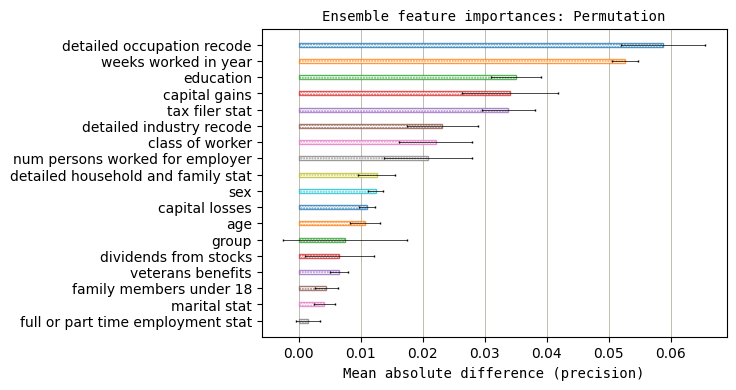

In [237]:
# Error bars -- one standard deviation
plot_bar(permut_importance_ensemble_avg, 'feature', 'importance_mean', f'Mean absolute difference ({metric})', 'Ensemble feature importances: Permutation', 'horizontal', err=permut_importance_ensemble['importances_std'])

Our finds are:
- Top-3 _most_ important features are `detailed occupation recode`, `weeks worked in year` and `education`;
- Top-3 _least_ important features are `family members under 18`, `marital stat`, and `full or part time employment stat`. 

Next, we'll look at Partial Dependence (PD) of the target from individual features. Here we can compute PD for the whole ensemble. This is the main advantage of this method — it works for any model, regardless of its underlying algorithm.

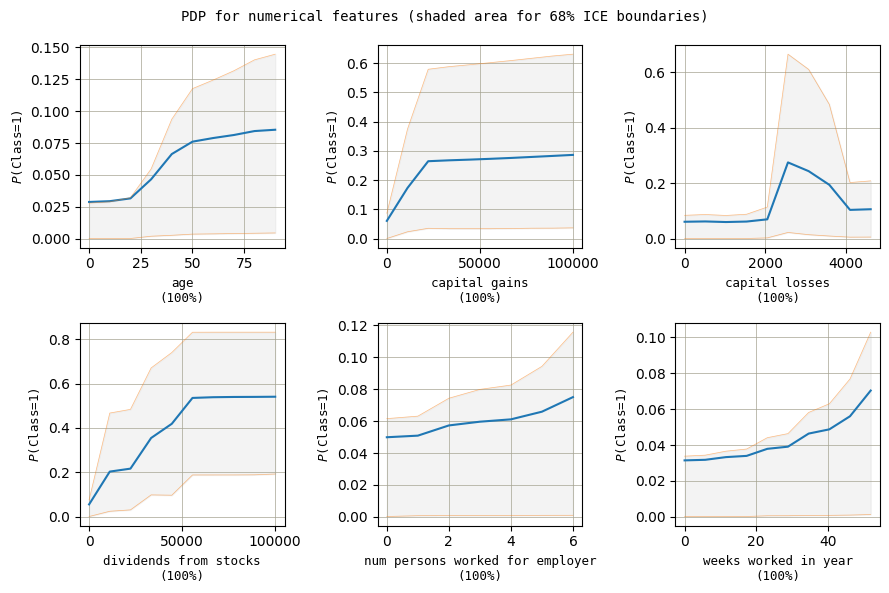

In [238]:
# Numerical features
ice_perc = 68 # %
feat_perc = 100 # %
ncols = 3
nrows = int(np.ceil(len(num_cols) / ncols))
plt.figure(figsize=(ncols * 3, nrows * 3))
for i, feature_name in enumerate(num_cols, start=1):
    plt.subplot(nrows, ncols, i)
    pdp_df = predict_partial(X_val, feature_name, model_ensemble, kind='num', grid_size=10, ice_perc=ice_perc, feat_perc=feat_perc)
    # Show PDP
    plt.plot(pdp_df['Value'], pdp_df['Pred_mean'], color='C0')
    # Show ICE as shaded area, as per `ice_perc`
    plt.plot(pdp_df['Value'], pdp_df['ICE_hi'], color='C1', lw=0.5, alpha=0.5)
    plt.plot(pdp_df['Value'], pdp_df['ICE_lo'], color='C1', lw=0.5, alpha=0.5)
    plt.fill_between(pdp_df['Value'], pdp_df['ICE_hi'], pdp_df['ICE_lo'], color='lightgrey', alpha=0.25)
    plt.xlabel(f'{feature_name}\n({feat_perc}%)', size=9, family='monospace')
    plt.ylabel('$P$(Class=1)', size=9, family='monospace')
    plt.suptitle(f'PDP for numerical features (shaded area for {ice_perc}% ICE boundaries)', size=10, family='monospace')
    plt.grid(lw=0.5, color='xkcd:cement')
plt.tight_layout();

Our findings:
- The target responds to all numerical features;
- Recall the age profile during feature engineering: middle-aged participants earn more than younger and older ones. Here we no longer observe this dependence. This is because our model has not only age, but another 17 features, and age still influences the target, but not solely.

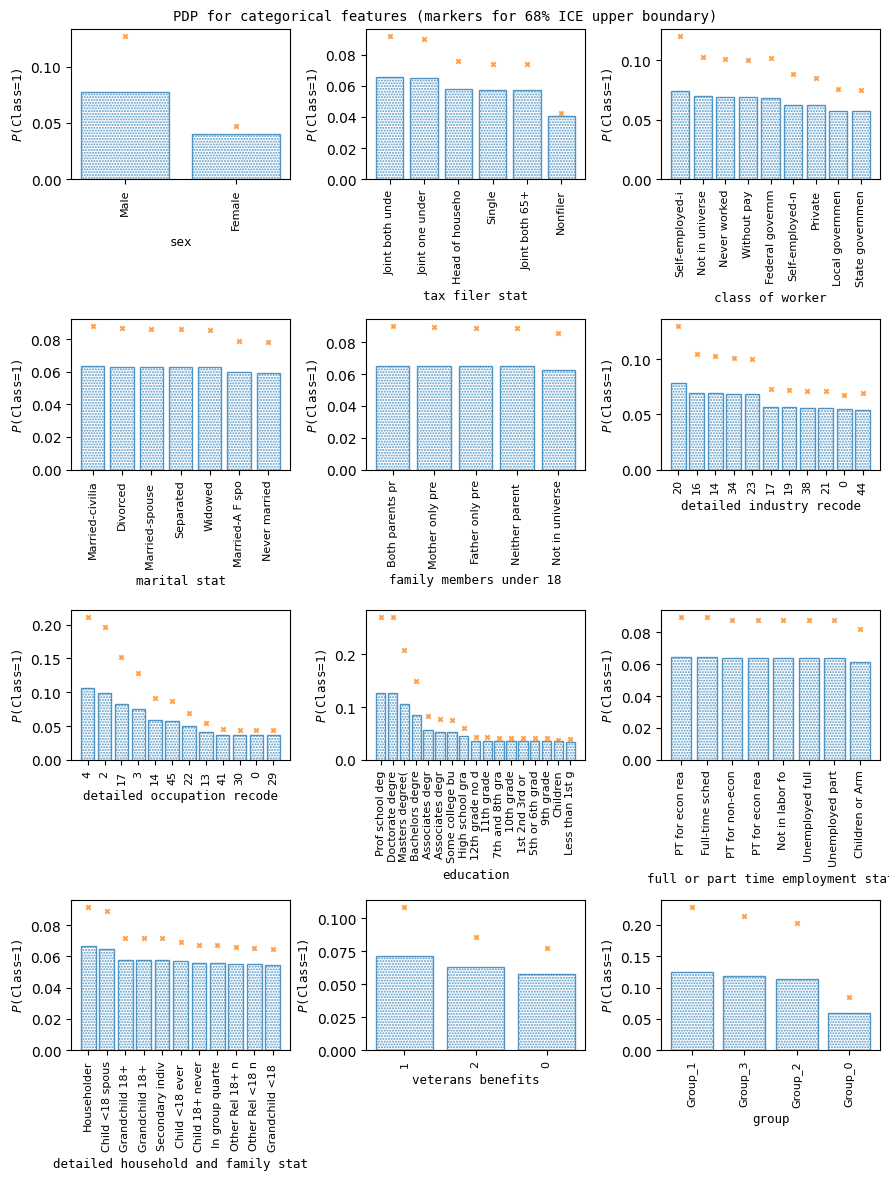

In [239]:
# Categorical features
ice_perc = 68 # %
ncols = 3
nrows = int(np.ceil(len(cat_cols) / ncols))
plt.figure(figsize=(ncols * 3, nrows * 3))
for i, feature_name in enumerate(cat_cols, start=1):
    plt.subplot(nrows, ncols, i)
    pdp_df = predict_partial(X_val, feature_name, model_ensemble, kind='cat', grid_size=10, ice_perc=ice_perc).sort_values(by='Pred_mean', ascending=False)
    # Show PDP
    plt.bar(pdp_df['Value'].astype(str), pdp_df['Pred_mean'], color='white', edgecolor='C0', alpha=0.75, hatch='.'*6, error_kw={'lw': 0.5, 'ecolor': 'black', 'capsize': 1})
    # Show ISE  upper boundary, as per `ice_perc`
    plt.scatter(pdp_df['Value'].astype(str), pdp_df['ICE_hi'], marker='x', s=10, color='C1', alpha=0.75)
    plt.xlabel(feature_name, size=9, family='monospace')
    plt.ylabel('$P$(Class=1)', size=9, family='monospace')
    plt.xticks(range(len(pdp_df['Value'])), [f'{str(_)[:15]}' for _ in pdp_df['Value']], size=8, rotation=90) # Limit xticks 
    plt.suptitle(f'PDP for categorical features (markers for {ice_perc}% ICE upper boundary)', size=10, family='monospace')
plt.tight_layout();

We can see that the target strongly responds to `education` and `detailed occupation recode` — among our top important features. At the same time, target does not seem to respond much to `full or part time employment stat` and ``family members under 18`` which are in the bottom of the feature importances list.

We would also like to apply the SHAP method, but unfortunately it does not support sklearn's VotingClassifier yet, so we'll stop our model interpretation here.

In [257]:
print('Most important features:')
print(f"Intersection for Impurity, SHAP, and Permutation: {set(feature_importances_best_single.head(3)['feature']) & set(shap_values_best_single_avg.head(3)['feature']) & set(permut_importance_ensemble_avg.head(3)['feature'])}")
print(f"Union for Impurity, SHAP, and Permutation: {set(feature_importances_best_single.head(3)['feature']) | set(shap_values_best_single_avg.head(3)['feature']) | set(permut_importance_ensemble_avg.head(3)['feature'])}")
print(f"{'':->20}")
print('Least important features:')
print(f"Intersection for Impurity, SHAP, and Permutation: {set(feature_importances_best_single.tail(3)['feature']) & set(shap_values_best_single_avg.tail(3)['feature']) & set(permut_importance_ensemble_avg.tail(3)['feature'])}")
print(f"Union for Impurity, SHAP, and Permutation: {set(feature_importances_best_single.tail(3)['feature']) | set(shap_values_best_single_avg.tail(3)['feature']) | set(permut_importance_ensemble_avg.tail(3)['feature'])}")

Most important features:
Intersection for Impurity, SHAP, and Permutation: {'detailed occupation recode', 'education'}
Union for Impurity, SHAP, and Permutation: {'detailed occupation recode', 'weeks worked in year', 'education', 'group'}
--------------------
Least important features:
Intersection for Impurity, SHAP, and Permutation: {'full or part time employment stat'}
Union for Impurity, SHAP, and Permutation: {'family members under 18', 'marital stat', 'class of worker', 'full or part time employment stat', 'capital losses', 'veterans benefits'}


We tried two different interpretation methods for the ensemble and, combining the obtained results with the best single model, we can conclude that the __target is mostly influenced by__:
- `detailed occupation recode` and `education`;
- other important features might be `group` and `weeks worked in year`.

The least influencing feature, as per all methods, is:
- `full or part time employment stat`;
- other less important features might be `family members under 18`, `marital stat`, `class of worker`, `capital losses`, and `veterans benefits`.

The final model's metrics on `test` are the following:

In [241]:
y_pred_test = model_ensemble.predict(X_test)
y_pred_proba_class_1_test = model_ensemble.predict_proba(X_test)[:, 1]
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_proba_class_1_test)
auc_test = auc(recall_test, precision_test)
print('Classes probability threshold = 0.5 (default)')
print(f'Precision = {precision_score(y_test, y_pred_test):.3f}')
print(f'Recall = {recall_score(y_test, y_pred_test):.3f}')
print(f'F1-score = {f1_score(y_test, y_pred_test):.3f}')
print(f'AUC = {auc_test:.2f}')

Classes probability threshold = 0.5 (default)
Precision = 0.778
Recall = 0.439
F1-score = 0.561
AUC = 0.67


Our target metric is precision, and based on it, the model's quality is rather good: $\approx$ 0.78, which means that, out of 100 persons predicted as earning more than 50'000 (class 1), 78 persons indeed earn more than 50'000 (roughly 4 true positives out of 5 predicted as positive). Also, we have confirmed that the model can explain the target response more or less to all 18 features. This allows us to construct the profile of a person with higher income (see below).

At the same time, the model has an obvious drawback — the recall is rather low $\approx$ 0.44. This means that out of 100 persons who in fact earn more than 50'000, the model can detect (recall) only 44 such persons. In simple words, our model is very skeptic. We need to provide much evidence (through features) to convince it to mark a person as a higher income one. But when the model finally "believes" that a person can earn more, its predictions are rather correct (precision is high). __Our model provides precise but not full predictions__. We will consider this result as acceptable, since our goal is to introduce a new extra income tax for individuals who indeed earn more than 50'000. We can tune the decision threshold to balance the precision and recall, if required.

For example, we can increase the recall to at least 0.5, so that the model would detect at least one half of all higher income participants.

In [242]:
# Search over thresholds in [0.0, 1.0]
for threshold in tqdm(np.linspace(0.0, 1.0, 1001)):
    y_pred_tuned = np.where(y_pred_proba_class_1_test >= threshold, 1, 0)
    recall_tuned = recall_score(y_test, y_pred_tuned)
    if recall_tuned < 0.501:
        threshold_recall_tuned = threshold
        print(f'{threshold_recall_tuned = :.3f}')
        break

 43%|████▎     | 429/1001 [00:04<00:05, 98.40it/s] 

threshold_recall_tuned = 0.429


Or we can do the opposite: make the classifier even more skeptic by requiring the precsion to be at least 0.9. We will find much fewer participants, but 90% of predicted will indeed have higher income.

In [243]:
for threshold in tqdm(np.linspace(0.0, 1.0, 1001)):
    y_pred_tuned = np.where(y_pred_proba_class_1_test >= threshold, 1, 0)
    precision_tuned = precision_score(y_test, y_pred_tuned)
    if precision_tuned > 0.9:
        threshold_precision_tuned = threshold
        print(f'{threshold_precision_tuned = :.3f}')
        break

 72%|███████▏  | 719/1001 [00:07<00:02, 96.67it/s] 


threshold_precision_tuned = 0.719


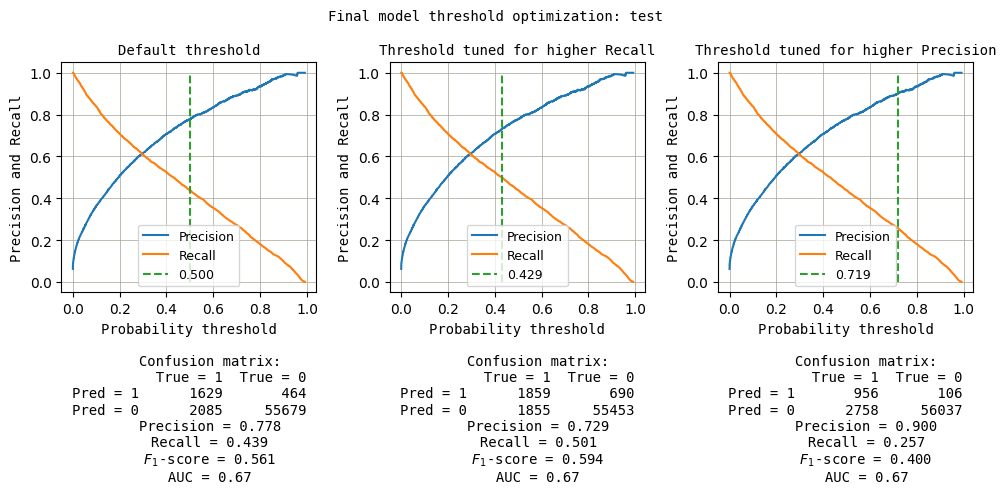

In [244]:
plt.figure(figsize=(10, 5))
for i in (1, 2, 3):
    if i == 1:
        threshold = 0.5
        title = 'Default threshold'
    elif i == 2:
        threshold = threshold_recall_tuned
        title = 'Threshold tuned for higher Recall'
    else: # i == 3
        threshold = threshold_precision_tuned
        title = 'Threshold tuned for higher Precision'
    plt.subplot(1, 3, i)
    plt.plot(thresholds_test, precision_test[:-1], color='C0', label='Precision')
    plt.plot(thresholds_test, recall_test[:-1], color='C1', label='Recall')
    plt.vlines(threshold, 0.0, 1.0, ls='--', color='C2', label=f'{threshold:.3f}')
    plt.ylabel('Precision and Recall', size=10, fontfamily='monospace')
    y_pred_tuned = np.where(y_pred_proba_class_1_test >= threshold, 1, 0)
    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred_tuned, labels=[1, 0]),
        columns=['Pred = 1', 'Pred = 0'],
        index=['True = 1', 'True = 0']).T
    plt.xlabel(f'Probability threshold\n\n \
    Confusion matrix:\n{cm}\n \
    Precision = {precision_score(y_test, y_pred_tuned):.3f}\n \
    Recall = {recall_score(y_test, y_pred_tuned):.3f}\n \
    $F_{1}$-score = {f1_score(y_test, y_pred_tuned):.3f}\n \
    AUC = {auc_test:.2f}', size=10, fontfamily='monospace')
    plt.title(f'{title}', size=10, fontfamily='monospace')
    plt.legend(fontsize=9)
    plt.grid(lw=0.5, color='xkcd:cement')
plt.suptitle('Final model threshold optimization: test', size=10, fontfamily='monospace')
plt.tight_layout();

> Quick warning: such precision-recall re-balancing will not change the AUC, which in fact indicates the intrinsic classification "power" of the model. Recall that dealing with class imbalance did not help make our classifier better.

Finally, let's take a look at the model's metrics on `train` to check, if it overfits.

In [245]:
y_pred_train = model_ensemble.predict(X_train)
y_pred_proba_class_1_train = model_ensemble.predict_proba(X_train)[:, 1]
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_class_1_train)
auc_train = auc(recall_train, precision_train)
print('Classes probability threshold = 0.5 (default)')
print(f'Precision = {precision_score(y_train, y_pred_train):.3f}')
print(f'Recall = {recall_score(y_train, y_pred_train):.3f}')
print(f'F1-score = {f1_score(y_train, y_pred_train):.3f}')
print(f'AUC = {auc_train:.2f}')

Classes probability threshold = 0.5 (default)
Precision = 0.767
Recall = 0.452
F1-score = 0.569
AUC = 0.68


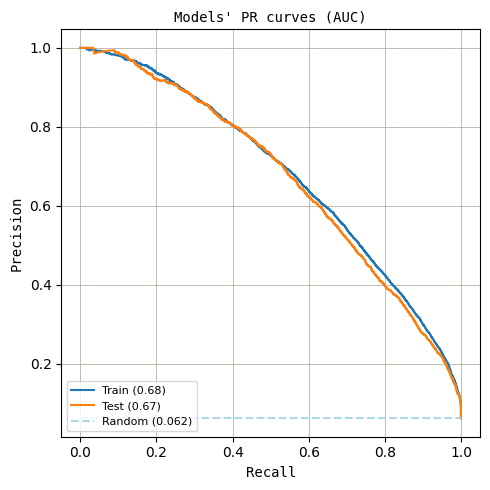

In [247]:
plt.figure(figsize=(5, 5))
plt.plot(recall_train, precision_train, color=f'C0', label=f'Train ({auc_train:.2f})')
plt.plot(recall_test, precision_test, color=f'C1', label=f'Test ({auc_test:.2f})')
plt.hlines(y_train.mean(), xmin=0.0, xmax=1.0, ls='--', color='lightblue', label=f'Random ({y_train.mean():.3f})')
plt.xlabel('Recall', size=10, fontfamily='monospace')
plt.ylabel('Precision', size=10, fontfamily='monospace')
plt.legend(loc='lower left', fontsize=8)
plt.grid(lw=0.5, color='xkcd:cement')
plt.title("Models' PR curves (AUC)", size=10, fontfamily='monospace')
plt.tight_layout();

The model almost does not overfit: $\text{AUC}_{train}$ = 0.68 vs $\text{AUC}_{test}$ = 0.67.

* 4.3. (9%) Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

We have built an income classifier which meets our goals:
- It has rather high Precision;
- It can explain the profile of participants who earn more than 50'000.

> The model helped us discover that individuals tend to earn more than 50'000, if they have the following features:
> - Employed in legal, business and financial operations, computer and mathematical science, architecture and engineering, office and administrative support occupations;
> - Work 30+ weeks in year;
> - Received high level of professional education, like masters and doctorate degrees.

To build our classifier, several machine learning techniques and algorithms were used:
- Feature engineering to select only relevant features that should explain the target variable;
- Unsupervised K-Means clustering to "summarize" numerical features and introduce a new feature;
- Supervised ML models of different nature from Logistic Regression to Random Forest to Gradient Boosting, including most advanced algorithms like CatBoost, XGBoost, and LightGBM, to finally building an ensemble of blended individual models with optimized contribution weights. This ensemble of best single models appeared to be the best overall model;
- During the whole course of actions we validated our results using either the fixed-size validation dataset or applying cross-validation on the train dataset;
- We estimated the final quality metrics on the test dataset and they proved to be acceptable;
- We applied model interpretation methods such as feature importance, permutation importance, partial dependence, and SHAP to better understand the interaction between the target and features;

At the same time some techniques did not work this time:
- We checked, if we could reduce the dimensionality with PCA but it didn't introduce new valuable information;
- Classes imbalance elimination — both undersampling and oversampling — did not help improve the quality of the classifier, so we didn't use it.

We should trust the obtained results, because:

- We correctly prepared the data with randomly shuffled splits, so the datasets used for training, validation, and testing should have the same distributions of all variables (i.i.d.), so sampling bias should be low;
- We tried to include only mutually independent features, so that each of them could explain its own influence on the target's variance;
- Most important, we did _not_ use misleading metrics, such as accuracy, for our severely imbalanced data (15:1 classes ratio), but only estimated metrics reflecting real and predicted distributions of the positive (minority) class;
- We understand that the model is biased toward detecting the most convincing candidates (Recall is low), and we report this fact;
- At the same time, the model does not overfit much, i.e. it has low variance;
- We applied model interpretation methods and proved that our features can explain the target's variance;
- We used industry-approved SW development and ML tools and libraries such as Python, sklearn, CatBoost, Matplotlib, etc.

Ideas for model's quality improvement:
- Spend more time on feature engineering. Try automatic feature selection methods, however, it can be very slow in sklearn (Python!);
- Try to use clustering  methods designed for categorical features (K-Modes maybe) and introduce new derived features;
- Do something with too many missing values in several variables. During feature engineering we saw that some variables have 50+% of missing values. Maybe use a more complete and consistent dataset;
- Find a better algorithm than Random Forest and Gradient Boosting (Artificial Neural Networks maybe).

Sources:
- <a id="val-strategy" href="https://edu.hse.ru/course/view.php?id=182099&section=4&singlesec=4">Validation strategies</a>
- <a id="feature-encoding" href="https://edu.hse.ru/course/view.php?id=182099&section=2&singlesec=2">Handling categorical data</a>
- <a id="handling-imbalance" href="https://edu.hse.ru/course/view.php?id=182099&section=5&singlesec=5">Handling imbalanced data</a>
- <a id="pca" href="https://edu.hse.ru/course/view.php?id=182099&section=7&singlesec=7">Principal Component Analysis</a>
- <a id="kmeans" href="https://edu.hse.ru/course/view.php?id=182099&section=7&singlesec=7">K-Means</a>
- <a id="feat-importance" href="https://edu.hse.ru/course/view.php?id=182099&section=4&singlesec=4">Interpretable models</a>
- <a id="occupation-recode" href="https://microdata.epi.org/variables/indocc/docc03/">Detailed occupation recode, 2003-present</a>



### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Support all your statements with calculations and plots. For instance, if you claim that the dataset does not have missing values, you need to provide the code which shows that the total number of missing values is zero